# cognee - demo

## Let's tackle the problem first

## Since LLMs appeared, people have tried to personalize them.
## You usually saw that by people doing "prompt engineering" and adding specific instructions to the LLM
## "Become a sales agent" or "Become a programmer"

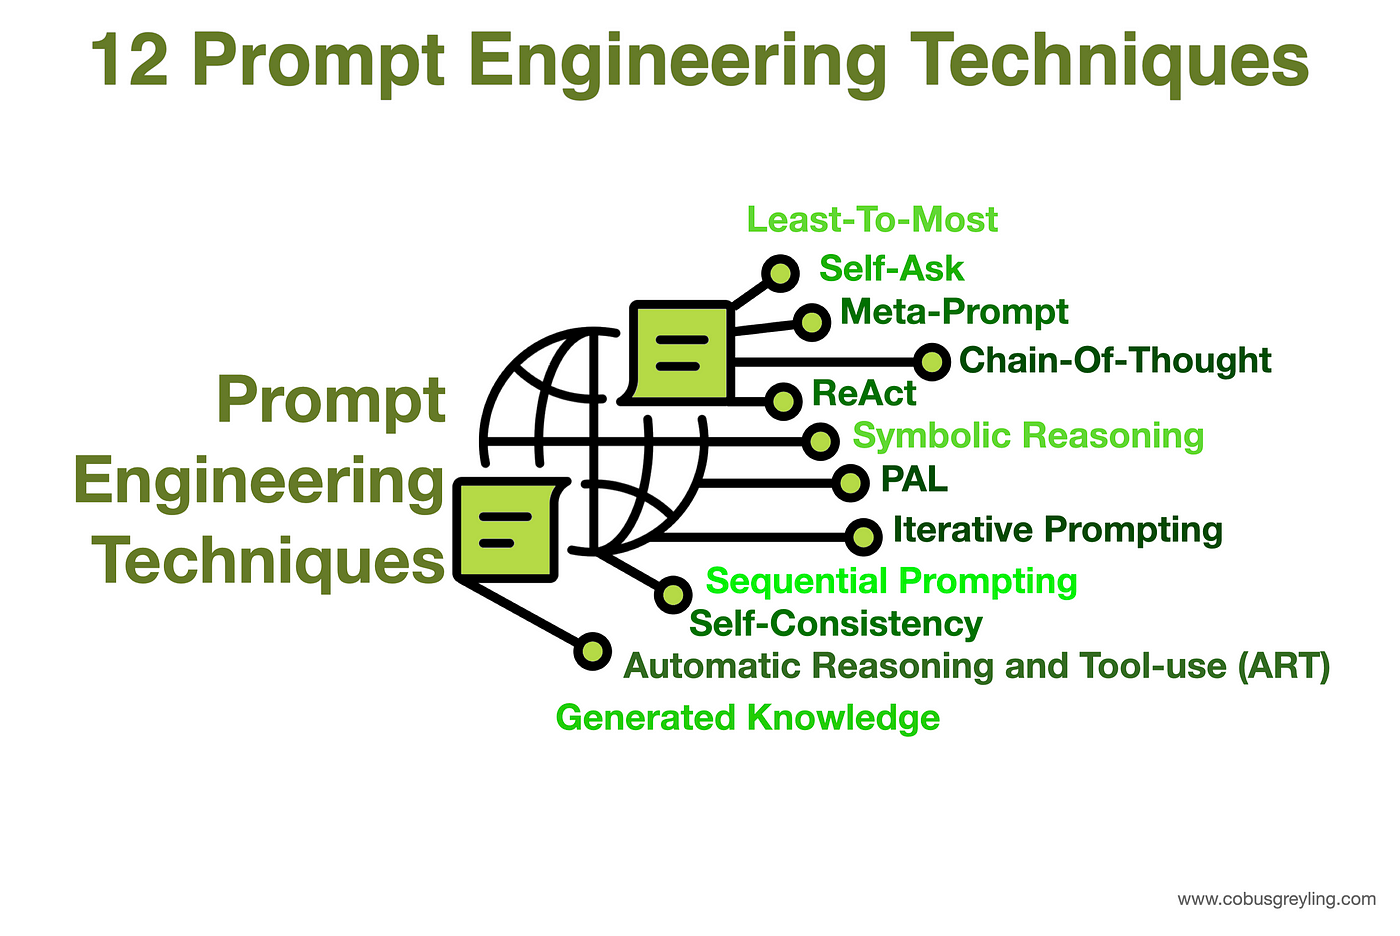

## The next popular thing was RAGs (Retrieval Augmented Generation) systems that connect to a vector store and search for similar data so they could enrich LLM response

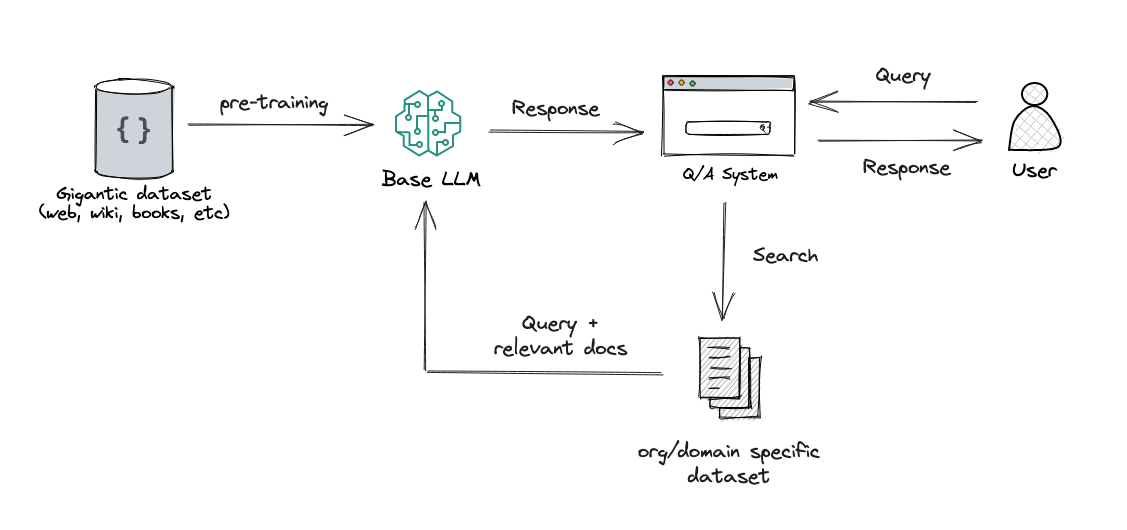


## The problem lies in the nature of the search. If you just find some keywords, and return one or many documents from vectorstore this way, you will have an issue with the way you would use to organise and prioritise documents. 
## If you search  for an apple, you might get both the information of your last laptop purchase, and the information about apple as a fruit.
## This fact makes it difficult to use vector databases and implies we might need another layer on top of them to have a semantic model LLMs could use
## How about graphs? 

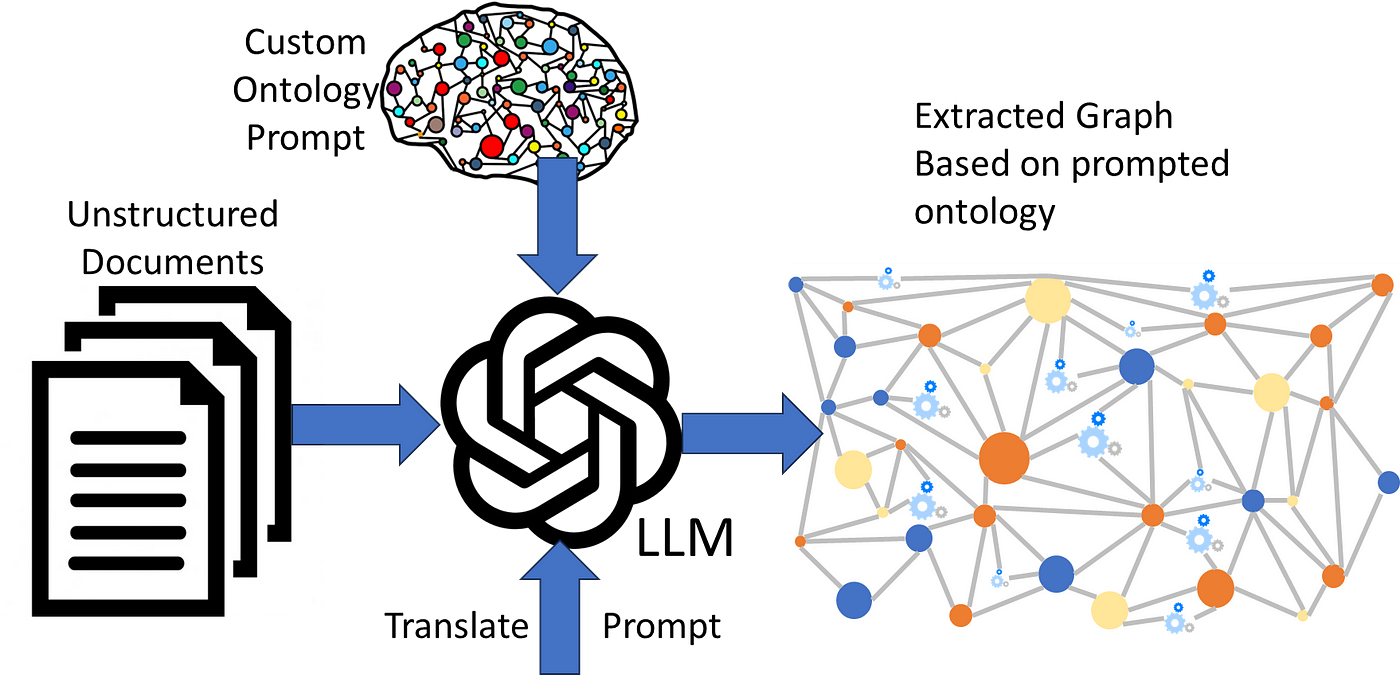

# HOW DOES IT WORK


## We first take some text from the internet, in this case two articles from the Guardian

In [1]:
import logging

from langchain.prompts import ChatPromptTemplate
import json
from langchain.document_loaders import TextLoader
from langchain.document_loaders import DirectoryLoader
from langchain.chains import create_extraction_chain
from langchain.chat_models import ChatOpenAI
import re

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()
import instructor
from openai import OpenAI


aclient = instructor.patch(OpenAI())

from typing import Optional, List
from pydantic import BaseModel, Field

from cognee.modules.cognify.llm.classify_content import classify_into_categories
from cognee.modules.cognify.llm.content_to_cog_layers import content_to_cog_layers
from cognee.modules.cognify.llm.generate_graph import generate_graph
from cognee.shared.data_models import DefaultContentPrediction,  KnowledgeGraph, DefaultCognitiveLayer



In [2]:
input_article_one = """ In the nicest possible way, Britons have always been a bit silly about animals. “Keeping pets, for the English, is not so much a leisure activity as it is an entire way of life,” wrote the anthropologist Kate Fox in Watching the English, nearly 20 years ago. Our dogs, in particular, have been an acceptable outlet for emotions and impulses we otherwise keep strictly controlled – our latent desire to be demonstratively affectionate, to be silly and chat to strangers. If this seems like an exaggeration, consider the different reactions you’d get if you struck up a conversation with someone in a park with a dog, versus someone on the train.

Indeed, British society has been set up to accommodate these four-legged ambassadors. In the UK – unlike Australia, say, or New Zealand – dogs are not just permitted on public transport but often openly encouraged. Many pubs and shops display waggish signs, reading, “Dogs welcome, people tolerated”, and have treat jars on their counters. The other day, as I was waiting outside a cafe with a friend’s dog, the barista urged me to bring her inside.

For years, Britons’ non-partisan passion for animals has been consistent amid dwindling common ground. But lately, rather than bringing out the best in us, our relationship with dogs is increasingly revealing us at our worst – and our supposed “best friends” are paying the price.

As with so many latent traits in the national psyche, it all came unleashed with the pandemic, when many people thought they might as well make the most of all that time at home and in local parks with a dog. Between 2019 and 2022, the number of pet dogs in the UK rose from about nine million to 13 million. But there’s long been a seasonal surge around this time of year, substantial enough for the Dogs Trust charity to coin its famous slogan back in 1978: “A dog is for life, not just for Christmas.”



"""

In [3]:
input_article_two = """Lee Parkin had been the proud owner of his terrier-spaniel cross Izzy for nearly 10 years when he stepped out for what would be his last walk with his beloved pet.

He was walking Izzy near his home in Doncaster when an XL bully pounced on her, mounting a 20-minute attack and ultimately killing the dog in front of Parkin, who desperately intervened in vain.

“It was such a nice day,” he said. “We were walking a normal field where I go, and I saw this dog loose. It appeared wild by its demeanour.”

Parkin, 50, took his dog through a gate but found himself cornered. The dog approached and started circling them. And then, he says, “it just grabbed her”.

“I’ve never encountered a bigger, stronger dog before in my life,” he says. “I’ve dealt with dogs attacking another dog before.”

Lee Parkin and his dog Izzy
Lee Parkin and his dog Izzy. Photograph: Lee Parkin
Parkin did his best to fight the dog off. “I smashed both hands against it, I twisted its balls, I kicked it in its back end. It did nothing whatsoever. I just shouted for help.”

At first there were no other people around, but “all of a sudden” there were about three other men, possibly including the owner, attempting to remove the animal.

A passerby gave him a lift to the vet but Izzy was “bleeding so profusely” he could hear her choking on her own blood. Her bones had been crushed.

The owners were handed a caution and the dog remains alive and living nearby.

“It was dangerously out of control,” Parkin says of the XL bully. “I’ve been brought up with dogs all my life. There’s no place for this type of dog in society.”

He welcomes the incoming ban on XL bullies but says he does not think it is enough and it will not work.

He believes the majority of XL bully owners will not be fazed by the ban and will keep their dogs and ignore the new law and regulations.

“The only effective thing that I’ve seen the police doing is turning up and shooting these dogs, which is what I think they should be doing,” Parkin adds.

He was left with significant mental impacts from the attack and was subsequently diagnosed with post-traumatic stress disorder. He received counselling but still struggles with walking dogs, and often rises very early in the morning to avoid other owners. He also carries a dog spray.

Marie Hay’s siberian husky, Naevia, survived a savage attack on the beach in Redcar on the North Yorkshire coast by two XL bullies – but has been left with life-changing injuries. Hay, like Parkin, has also been left with mental scars.

The owner of the dog that attacked seven-year-old Naevia is facing a criminal trial next year.

“We must have only been three minutes and the guy pulls up and basically he’s just got his dogs out of the car. They run down to the bottom of the beach and one starts to run towards Naevia.

“The owner turned to me and said: ‘They’re friendly, don’t worry,’ because I must have pulled a face at the size of the dog.

skip past newsletter promotion
Sign up to First Edition

Free daily newsletter
Our morning email breaks down the key stories of the day, telling you what’s happening and why it matters

Enter your email address
Sign up
Privacy Notice: Newsletters may contain info about charities, online ads, and content funded by outside parties. For more information see our Privacy Policy. We use Google reCaptcha to protect our website and the Google Privacy Policy and Terms of Service apply.
after newsletter promotion
“But then the first one jumped on Naevia’s chest and just started tearing into her.

“So she was screaming, screaming like a baby. And then the other one just came out of nowhere. The attack lasted about 12 minutes.”

An American bully XL with cropped ears. The practice is illegal in England and Wales, but it is still carried out by unscrupulous owners.
Perfect pets or dangerous dogs? The sudden, surprising rise of American bully XLs
Read more
Hay said several people attempted to remove the dogs but were initially unsuccessful. They attempted to lift the dogs by the legs and her 20-year-old daughter was bitten, as were other people who intervened.

The owner eventually placed a harness on one of them and put it in the car, while Hay had to walk the other dog back to the car on a lead.

Naevia lost 83% of her blood. “She was bleeding to death on the beach … she had hundreds of bite marks all over, she had an incision that ripped her chest open.

“She had to have between eight and 10 operations. She’s now in kidney failure because of the stress that it caused on her kidneys. She had to have two blood transfusions.”

Hay said the vet bills were more than £30,000, which she has been able to cover through donations on a fundraising website.

Like Parkin, Hay struggles to go out for walks now, due to the stress caused by the incident.

“I carry a full kit that I’ve made myself, it’s got a rape alarm, a couple of extra dog leads … I’m constantly in fear.”

Hay says she is “100%” supportive of the new ban. She says she accepts that a dog’s behaviour is partly down to the owners but is confident the breed plays a part too."""

## Our goal is to create a semantic representation of the data and split the data into a multilayer graph network containing propositions

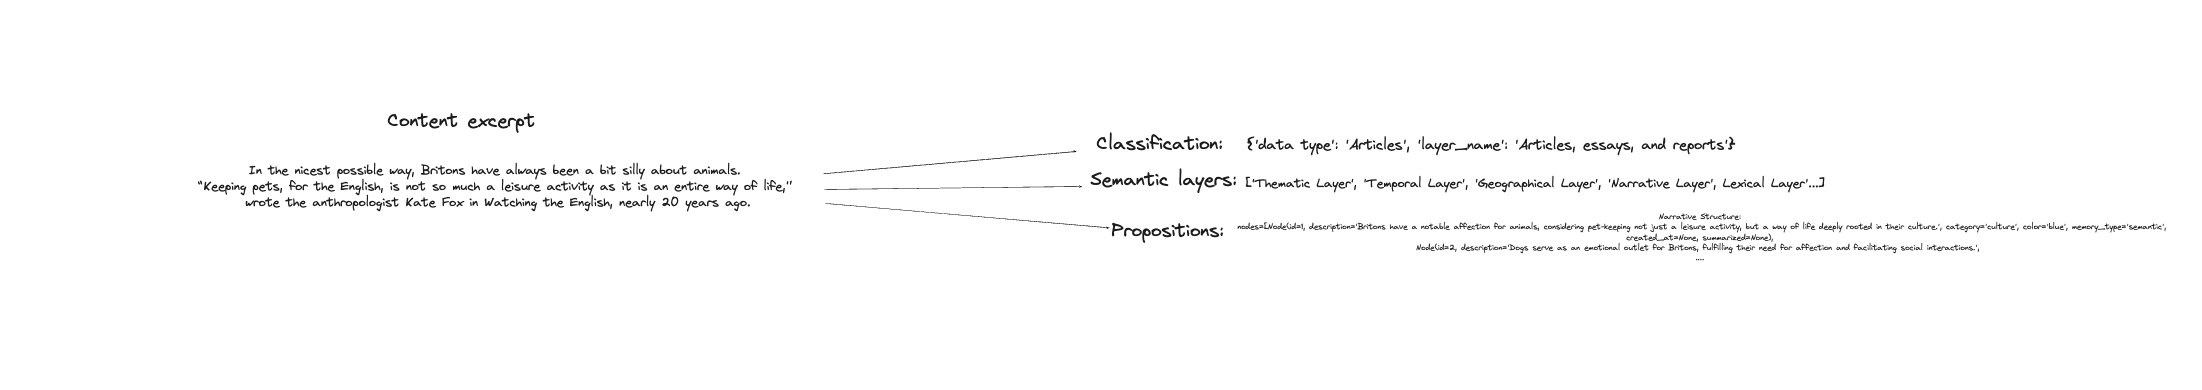

## What is a semantic layer and what are propositions

## Multilayer network is cognitive multilayer networks as a  quantitative and interpretative framework for investigating the mental lexicon. The mental lexicon is a complex cognitive system representing information about the words/concepts that one knows
Article 2

## A proposition is: Propositions are defined as atomic expressions within text, each encapsulating a distinct factoid and presented in a concise, self-contained natural language format.
Article 1

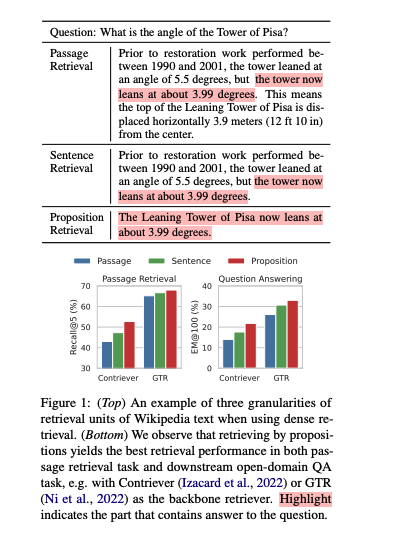 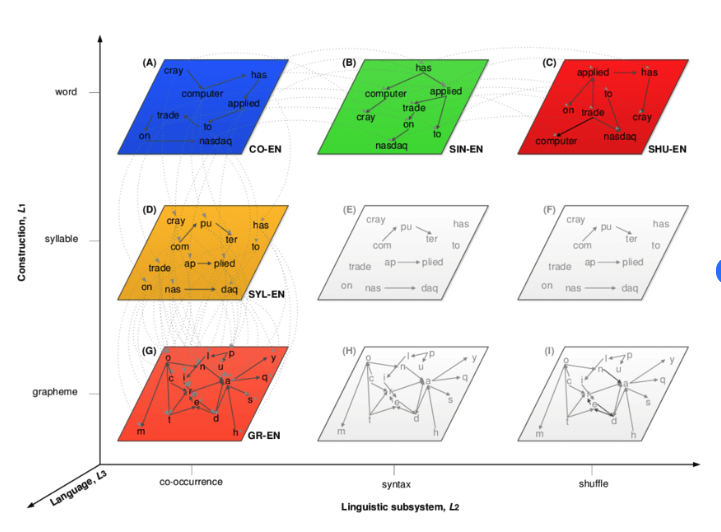

## We combine the concepts of Multilayer networks with the propositions to create a semantic knowledge graph

Relevant articles are: https://arxiv.org/pdf/2312.06648.pdf and   https://link.springer.com/article/10.3758/s13423-024-02473-9

## We start using Cognee by getting the prepared data and understanding what type of data it is, using LLMs

In [4]:
import os
from cognee.modules.cognify.llm.classify_content import classify_into_categories
from cognee.modules.cognify.llm.content_to_cog_layers import content_to_cog_layers
from cognee.modules.cognify.llm.generate_graph import generate_graph
from cognee.shared.data_models import DefaultContentPrediction,  KnowledgeGraph, DefaultCognitiveLayer
# from cognee.modules.cognify.graph import create_semantic_graph

In [5]:
required_layers_one = await classify_into_categories(input_article_one, "classify_content.txt", DefaultContentPrediction)

In [6]:
print(required_layers_one.dict())

{'label': {'type': 'TEXT', 'subclass': [<TextSubclass.ARTICLES: 'Articles, essays, and reports'>]}}


In [7]:
#note that you can provide your own Pydantic model that would represent your own categorisation
required_layers_two = await classify_into_categories(input_article_two, "classify_content.txt", DefaultContentPrediction)

In [8]:
print(required_layers_two.dict())

{'label': {'type': 'TEXT', 'subclass': [<TextSubclass.NEWS_STORIES: 'News stories and blog posts'>]}}


## Now that we have content categories, it is time to provide them to our graph generation prompt

The goal of this section is to make sure that we can turn our information into a set of relevant cognitive layers.
Layers can be anything like "word", or "sentence" to some categories like "movies" or "fruits" 
In this case, we let the LLM decide what the appropriate layers are.

In [9]:
def transform_dict(original):
    # Extract the first subclass from the list (assuming there could be more)
    subclass_enum = original['label']['subclass'][0]


    # The data type is derived from 'type' and converted to lowercase
    data_type = original['label']['type'].lower()
    
    # The context name is the name of the Enum member (e.g., 'NEWS_STORIES')
    context_name = subclass_enum.name.replace('_', ' ').title()
    
    # The layer name is the value of the Enum member (e.g., 'News stories and blog posts')
    layer_name = subclass_enum.value

    # Construct the new dictionary
    new_dict = {
        'data_type': data_type,
        'context_name': data_type.upper(), #llm context classification
        'layer_name': layer_name #llm layer classification
    }

    return new_dict

# Transform the original dictionary
transformed_dict_1 = transform_dict(required_layers_one.dict())
transformed_dict_2 = transform_dict(required_layers_two.dict())



In [10]:
transformed_dict_1

{'data_type': 'text',
 'context_name': 'TEXT',
 'layer_name': 'Articles, essays, and reports'}

In [11]:
cognitive_layers_one = await content_to_cog_layers(transformed_dict_1, response_model=DefaultCognitiveLayer)

In [12]:
cognitive_layers_two = await content_to_cog_layers(transformed_dict_2, response_model=DefaultCognitiveLayer)

In [13]:
cognitive_layers_one = [layer_subgroup.name for layer_subgroup in cognitive_layers_one.cognitive_layers]

print("Extracted Layer Names:", cognitive_layers_one)

Extracted Layer Names: ['Structural Analysis', 'Thematic Analysis', 'Semantic Analysis', 'Sentiment Analysis', 'Referential Analysis', 'Lexical Richness', 'Authorship Style']


In [14]:
cognitive_layers_two = [layer_subgroup.name for layer_subgroup in cognitive_layers_two.cognitive_layers]

print("Extracted Layer Names:", cognitive_layers_two)

Extracted Layer Names: ['Thematic Layer', 'Semantic Layer', 'Structural Layer', 'Entity Layer', 'Sentiment Layer', 'Temporal Layer', 'Source Layer']


In [15]:
# Now we decompose each layer into a relevant graph that extracts information from the text and focuses on exactly that semantic aspect of the text

In [16]:
transformed_dict_1

{'data_type': 'text',
 'context_name': 'TEXT',
 'layer_name': 'Articles, essays, and reports'}

In [17]:
def add_classification_nodes(G, id, classification_data):

    context = classification_data['context_name']
    layer = classification_data['layer_name']

    # Create the layer classification node ID using the context_name
    layer_classification_node_id = f'LLM_LAYER_CLASSIFICATION:{context}:{id}'

    # Add the node to the graph, unpacking the node data from the dictionary
    G.add_node(layer_classification_node_id, **classification_data)
    
    # Link this node to the corresponding document node
    G.add_edge(id, layer_classification_node_id, relationship='classified_as')

    # Create the detailed classification node ID using the context_name
    detailed_classification_node_id = f'LLM_CLASSIFICATION:LAYER:{layer}:{id}'

    # Add the detailed classification node, reusing the same node data
    G.add_node(detailed_classification_node_id, **classification_data)
    
    # Link the detailed classification node to the layer classification node
    G.add_edge(layer_classification_node_id, detailed_classification_node_id, relationship='contains_analysis')
    return G

In [18]:
import networkx as nx
from pydantic import BaseModel
from typing import Optional, Any, List, Dict
from datetime import datetime

# Models for representing different entities
class Relationship(BaseModel):
    type: str
    properties: Optional[Dict[str, Any]] = None

class DocumentType(BaseModel):
    type_id: str
    description: str
    default_relationship: Relationship = Relationship(type='is_type')

class Category(BaseModel):
    category_id: str
    name: str
    default_relationship: Relationship = Relationship(type='categorized_as')

class Document(BaseModel):
    doc_id: str
    title: str
    summary: Optional[str] = None
    content_id: Optional[str] = None
    doc_type: Optional[DocumentType] = None
    categories: List[Category] = []
    default_relationship: Relationship = Relationship(type='has_document')

class UserLocation(BaseModel):
    location_id: str
    description: str
    default_relationship: Relationship = Relationship(type='located_in')

class UserProperties(BaseModel):
    custom_properties: Optional[Dict[str, Any]] = None
    location: Optional[UserLocation] = None

class GraphModel(BaseModel):
    id: str
    user_properties: UserProperties = UserProperties()
    documents: List[Document] = []
    default_fields: Optional[Dict[str, Any]] = {}

def generate_node_id(instance: BaseModel) -> str:
    for field in ['id', 'doc_id', 'location_id', 'type_id']:
        if hasattr(instance, field):
            return f"{instance.__class__.__name__}:{getattr(instance, field)}"
    return f"{instance.__class__.__name__}:default"

def add_node_and_edge(G, parent_id: Optional[str], node_id: str, node_data: dict, relationship_data: dict):
    G.add_node(node_id, **node_data)  # Add the current node with its data
    if parent_id:
        # Add an edge between the parent node and the current node with the correct relationship data
        G.add_edge(parent_id, node_id, **relationship_data)

def process_attribute(G, parent_id: Optional[str], attribute: str, value: Any):
    if isinstance(value, BaseModel):
        node_id = generate_node_id(value)
        node_data = value.dict(exclude={'default_relationship'})
        # Use the specified default relationship for the edge between the parent node and the current node
        relationship_data = value.default_relationship.dict() if hasattr(value, 'default_relationship') else {}
        add_node_and_edge(G, parent_id, node_id, node_data, relationship_data)

        # Recursively process nested attributes to ensure all nodes and relationships are added to the graph
        for sub_attr, sub_val in value.__dict__.items():  # Access attributes and their values directly
            process_attribute(G, node_id, sub_attr, sub_val)

    elif isinstance(value, list) and all(isinstance(item, BaseModel) for item in value):
        # For lists of BaseModel instances, process each item in the list
        for item in value:
            process_attribute(G, parent_id, attribute, item)

def create_dynamic(graph_model: BaseModel, existing_graph: Optional[nx.Graph] = None) -> nx.Graph:
    G = existing_graph or nx.Graph()
    root_id = generate_node_id(graph_model)
    print(root_id)
    G.add_node(root_id, **graph_model.dict(exclude={'default_relationship'}))

    for attribute_name, attribute_value in graph_model:
        process_attribute(G, root_id, attribute_name, attribute_value)

    return G

# Example usage with GraphModel instance


In [19]:
graph_model_instance = GraphModel(
    id="user123",
    documents=[
        Document(
            doc_id="doc1",
            title="Document 1",
            summary="Summary of Document 1",
            content_id="content_id_for_doc1",  # Assuming external content storage ID
            doc_type=DocumentType(type_id="PDF", description="Portable Document Format"),
            categories=[
                Category(category_id="finance", name="Finance", default_relationship=Relationship(type="belongs_to")),
                Category(category_id="tech", name="Technology", default_relationship=Relationship(type="belongs_to"))
            ],
            default_relationship=Relationship(type='has_document')
        ),
        Document(
            doc_id="doc2",
            title="Document 2",
            summary="Summary of Document 2",
            content_id="content_id_for_doc2",
            doc_type=DocumentType(type_id="TXT", description="Text File"),
            categories=[
                Category(category_id="health", name="Health", default_relationship=Relationship(type="belongs_to")),
                Category(category_id="wellness", name="Wellness", default_relationship=Relationship(type="belongs_to"))
            ],
            default_relationship=Relationship(type='has_document')
        )
    ],
    user_properties=UserProperties(
        custom_properties={"age": "30"},
        location=UserLocation(location_id="ny", description="New York", default_relationship=Relationship(type='located_in'))
    ),
    default_fields={
        'created_at': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'updated_at': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
)


In [20]:
R = create_dynamic(graph_model_instance)

GraphModel:user123


In [21]:
U =add_classification_nodes(R, "Document:doc1",transformed_dict_1)

In [22]:
cognitive_layers_one

['Structural Analysis',
 'Thematic Analysis',
 'Semantic Analysis',
 'Sentiment Analysis',
 'Referential Analysis',
 'Lexical Richness',
 'Authorship Style']

In [23]:
import nest_asyncio
nest_asyncio.apply()
import asyncio
from typing import List, Type

# Assuming generate_graph, KnowledgeGraph, and other necessary components are defined elsewhere

async def generate_graphs_for_all_layers(text_input: str, layers: List[str], response_model: Type[BaseModel]):
    tasks = [generate_graph(text_input, "generate_graph_prompt.txt", {'layer': layer}, response_model) for layer in layers]
    return await asyncio.gather(*tasks)

# Execute the async function and print results for each set of layers
async def async_graph_per_layer(text_input: str, cognitive_layers: List[str]):
    graphs = await generate_graphs_for_all_layers(text_input, cognitive_layers, KnowledgeGraph)
    # for layer, graph in zip(cognitive_layers, graphs):
    #     print(f"{layer}: {graph}")
    return graphs
        

# Run the async function for each set of cognitive layers
layer_1_graph = await async_graph_per_layer(input_article_one, cognitive_layers_one)
# layer_2_graph = await async_graph_per_layer(input_article_one, cognitive_layers_two)


In [24]:
# import ast 


In [25]:
layer_2_graph = await async_graph_per_layer(input_article_one, cognitive_layers_two)

In [26]:
# for n,y in layer_1_graph[0].items():
#     print(ast.literal_eval(n)['layer'])

In [27]:
import graphistry
import pandas as pd
import networkx as nx

# Assuming Graphistry is already configured with API key
# graphistry.register(api=3, username='your_username', password='your_password')

# Convert NetworkX graph to a Pandas DataFrame
edges = nx.to_pandas_edgelist(U)
graphistry.register(api=3, username='Vasilije1990', password='Q@HLdgv5SMUsGxy') 

# Visualize the graph
graphistry.edges(edges, 'source', 'target').plot()

In [28]:
def append_data_to_graph(G, category_name, subclass_content,layer_description, new_data, layer_uuid, layer_decomposition_uuid):
    # Find the node ID for the subclass within the category
    subclass_node_id = None
    for node, data in G.nodes(data=True):
        if subclass_content in node:
            subclass_node_id = node

            print(subclass_node_id)

    if not subclass_node_id:
        print(f"Subclass '{subclass_content}' under category '{category_name}' not found in the graph.")
        return G

    # Mapping from old node IDs to new node IDs
    node_id_mapping = {}

    # Add nodes from the Pydantic object
    for node in new_data.nodes:
        unique_node_id =uuid.uuid4()
        new_node_id = f"{node.description} - {str(layer_uuid)}  - {str(layer_decomposition_uuid)} - {str(unique_node_id)}"
        G.add_node(new_node_id, 
                   created_at=datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 
                   updated_at=datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 
                   description=node.description, 
                   category=node.category, 
                   memory_type=node.memory_type, 
                   layer_uuid = str(layer_uuid),
                   layer_description = str(layer_description),
                   layer_decomposition_uuid = str(layer_decomposition_uuid),
                   id = str(unique_node_id),
                   type='detail')
        G.add_edge(subclass_node_id, new_node_id, relationship='detail')

        # Store the mapping from old node ID to new node ID
        node_id_mapping[node.id] = new_node_id

    # Add edges from the Pydantic object using the new node IDs
    for edge in new_data.edges:
        # Use the mapping to get the new node IDs
        source_node_id = node_id_mapping.get(edge.source)
        target_node_id = node_id_mapping.get(edge.target)

        if source_node_id and target_node_id:
            G.add_edge(source_node_id, target_node_id, description=edge.description, relationship='relation')
        else:
            print(f"Could not find mapping for edge from {edge.source} to {edge.target}")

    return G


In [29]:
import uuid 
import json
def append_to_graph(layer_graphs, required_layers, G):
    # Generate a UUID for the overall layer
    layer_uuid = uuid.uuid4()
    
    # Extract category name from required_layers data
    category_name = required_layers.dict()['label']['type']

    # Extract subgroup name from required_layers data
    # Assuming there's always at least one subclass and we're taking the first
    subgroup_name = required_layers.dict()['label']['subclass'][0].value  # Access the value of the enum

    for layer_ind in layer_graphs:

        for layer_json, knowledge_graph in layer_ind.items():
            # Decode the JSON key to get the layer description
            layer_description = json.loads(layer_json)
    
            # Generate a UUID for this particular layer decomposition
            layer_decomposition_uuid = uuid.uuid4()
    
            # Assuming append_data_to_graph is defined elsewhere and appends data to G
            # You would pass relevant information from knowledge_graph along with other details to this function
            F = append_data_to_graph(G, category_name, subgroup_name, layer_description, knowledge_graph, layer_uuid, layer_decomposition_uuid)
            
            # Print updated graph for verification (assuming F is the updated NetworkX Graph)
            print("Updated Nodes:", F.nodes(data=True))

    return F

In [30]:
required_layers_one

DefaultContentPrediction(label=TextContent(type='TEXT', subclass=[<TextSubclass.ARTICLES: 'Articles, essays, and reports'>]))

In [31]:

T = append_to_graph(layer_1_graph, required_layers_one, U)

LLM_CLASSIFICATION:LAYER:Articles, essays, and reports:Document:doc1
Updated Nodes: [('GraphModel:user123', {'id': 'user123', 'user_properties': {'custom_properties': {'age': '30'}, 'location': {'location_id': 'ny', 'description': 'New York', 'default_relationship': {'type': 'located_in', 'properties': None}}}, 'documents': [{'doc_id': 'doc1', 'title': 'Document 1', 'summary': 'Summary of Document 1', 'content_id': 'content_id_for_doc1', 'doc_type': {'type_id': 'PDF', 'description': 'Portable Document Format', 'default_relationship': {'type': 'is_type', 'properties': None}}, 'categories': [{'category_id': 'finance', 'name': 'Finance', 'default_relationship': {'type': 'belongs_to', 'properties': None}}, {'category_id': 'tech', 'name': 'Technology', 'default_relationship': {'type': 'belongs_to', 'properties': None}}], 'default_relationship': {'type': 'has_document', 'properties': None}}, {'doc_id': 'doc2', 'title': 'Document 2', 'summary': 'Summary of Document 2', 'content_id': 'content_

In [32]:
# R = append_to_graph(layer_2_graph, required_layers_two, U)

In [117]:
import graphistry
import pandas as pd

# Assuming Graphistry is already configured with API key
# graphistry.register(api=3, username='your_username', password='your_password')

# Convert NetworkX graph to a Pandas DataFrame
edges = nx.to_pandas_edgelist(T)
graphistry.register(api=3, username=os.getenv('GRAPHISTRY_USERNAME'), password=os.getenv('GRAPHISTRY_PASSWORD')) 

# Visualize the graph
graphistry.edges(edges, 'source', 'target').plot()

In [34]:
## Utility to check if relationships are as they should be

In [35]:
# def list_graph_relationships_with_node_attributes(graph):
#     print("Graph Relationships with Node Attributes:")
#     for source, target, data in graph.edges(data=True):
#         # Get source and target node attributes
#         source_attrs = graph.nodes[source]
#         target_attrs = graph.nodes[target]
#         relationship = data.get('relationship', 'No relationship specified')

#         # Format and print source and target node attributes along with the relationship
#         source_attrs_formatted = ', '.join([f"{k}: {v}" for k, v in source_attrs.items()])
#         target_attrs_formatted = ', '.join([f"{k}: {v}" for k, v in target_attrs.items()])
        
#         print(f"Source [{source_attrs_formatted}] -> Target [{target_attrs_formatted}]: Relationship [{relationship}]")

# # Assuming 'F' is your graph instance
# list_graph_relationships_with_node_attributes(G)

In [36]:
# def extract_node_descriptions(data):
#     descriptions = []
#     for node_id, attributes in data:
#         # Check if both 'description' and 'layer_id' are in the attributes
#         if 'description' in attributes and 'layer_id' in attributes and 'layer_uuid' in attributes:
#             descriptions.append({
#                 'node_id': node_id, 
#                 'description': attributes['description'],
#                 'layer_uuid': attributes['layer_uuid']  # Include layer_id
#             })
#     return descriptions

# # Extract the node descriptions
# node_descriptions = extract_node_descriptions(R.nodes(data=True))

# # Display the results (displaying a subset for brevity)
# for item in node_descriptions[:5]:  # Adjust the slice as needed for display
#     print(item)

In [37]:
# descriptions = []
# for node_id, attributes in R.nodes(data=True):
#     if 'description' in attributes:
#         descriptions.append({'node_id': node_id, 'description': attributes['description'], 'layer_uuid': attributes['layer_uuid'], 'layer_decomposition_uuid': attributes['layer_decomposition_uuid']})


In [122]:
bb =[{'node_id': '32b11173-ab64-4741-9a36-c58300525efb', 'description': 'People of Britain', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': 'cf603ed2-917e-4519-82cf-4481cffd0a16', 'description': 'Non-human living beings', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': 'c67b6aaa-bc74-4f13-ada4-308b954bfd16', 'description': 'Animals kept for companionship', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': '3c24b71a-9bff-40be-bcc2-a9ac4e4038d7', 'description': 'A type of pet, often considered as humans best friend', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': '80dee8b8-c131-4dfd-983b-7018ca37f0ac', 'description': 'Anthropologist who wrote Watching the English, nearly 20 years ago', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': '0ba68c23-1d72-4547-8c77-775ef1736f19', 'description': 'Global health crisis that increased pet dog ownership in the UK', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': '63dabc5d-746b-4762-bb8d-3a2e81cacdc2', 'description': 'Charity that coined the slogan A dog is for life, not just for Christmas in 1978', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': '0ee75618-4bfb-42cb-8de6-1b3efbef9402', 'description': 'Time period between 2019 and 2022', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'}, {'node_id': 'f5a9f247-1816-4e55-a89b-b9b516e60dca', 'description': 'Britons have always been a bit silly about animals', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': '43a44379-a5ae-4832-8543-e3c862f32e07', 'description': 'In the UK, keeping pets is considered an entire way of life', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': 'aa0a62c0-780c-4b4c-bf69-1478a418a229', 'description': 'Dogs serve as an acceptable outlet for emotions and impulses in the UK', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': '5f9eb7c3-9c5e-4dd6-b158-6765d2fb0835', 'description': 'In the UK, dogs are often encouraged on public transport', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': '6ba46f17-a801-4b62-8b50-f82a46a7a97a', 'description': 'Many pubs and shops in the UK welcome dogs', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': '87bc41a4-181b-4c79-9563-ea33440ddd4d', 'description': 'Pet dog ownership in the UK rose from nine million to 13 million between 2019 and 2022 due to the pandemic', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': 'd3b36591-9f41-4d64-9ce1-435f707ec35a', 'description': 'A dog is for life, not just for Christmas - Dogs Trust slogan', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'b47fe3d3-c84e-4fdb-b90d-746c4d42dc04'}, {'node_id': 'c30d9605-b1a9-4794-972c-6581e07ad94c', 'description': 'Britons have always been passionate about animals, considering keeping pets as an entire way of life.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '03c1865f-86ef-40e8-9dfd-809aec4f247a'}, {'node_id': 'd3992373-b3ad-4269-a35f-8dbb1233d9c4', 'description': 'Dogs serve as an acceptable outlet for emotions and impulses such as affection and social interaction among Britons.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '03c1865f-86ef-40e8-9dfd-809aec4f247a'}, {'node_id': '1ae29ee0-8d58-45cc-9cb2-b508ad245cfd', 'description': 'The COVID-19 pandemic led to a significant increase in the number of pet dogs in the UK, from about nine million to 13 million between 2019 and 2022.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '03c1865f-86ef-40e8-9dfd-809aec4f247a'}, {'node_id': '88fc2e46-22ae-445f-bc8a-87da750d4ae1', 'description': 'A famous slogan coined by the Dogs Trust charity in 1978, emphasizing that dogs are lifelong commitments.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '03c1865f-86ef-40e8-9dfd-809aec4f247a'}, {'node_id': 'dd576909-760d-4ba3-8e92-be04acf9bba9', 'description': 'Britons have a notable attachment to animals, particularly considering them an integral part of their lifestyle and a means to express emotions.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'f0e301a6-7e87-4d7b-8bbd-b684e67049f1'}, {'node_id': '88b22148-5f0f-435b-87ff-bef93d016335', 'description': 'Kate Fox is an anthropologist who wrote about the importance of pets in English culture in her book Watching the English nearly 20 years ago.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'f0e301a6-7e87-4d7b-8bbd-b684e67049f1'}, {'node_id': 'f091de12-9e95-4ebf-ae8d-cefb589faf56', 'description': 'In British culture, dogs serve as outlets for emotions and interactions, including affection and communication with strangers.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'f0e301a6-7e87-4d7b-8bbd-b684e67049f1'}, {'node_id': 'e1bf4f50-12be-47ae-9b43-cde85ba568e7', 'description': 'In the UK, unlike Australia or New Zealand, dogs are not only allowed but encouraged on public transport.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'f0e301a6-7e87-4d7b-8bbd-b684e67049f1'}, {'node_id': 'c102ac94-5634-400f-a171-4a75c20a652a', 'description': 'Between 2019 and 2022, pet dog ownership in the UK rose from about 9 million to 13 million due to the pandemic.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'f0e301a6-7e87-4d7b-8bbd-b684e67049f1'}, {'node_id': '9f1e7f7a-fb83-4697-a528-74912f364b13', 'description': 'Dogs Trust is a charity that coined the slogan "A dog is for life, not just for Christmas" back in 1978.', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'f0e301a6-7e87-4d7b-8bbd-b684e67049f1'}, {'node_id': '6385c542-da46-4c29-8cc5-41316e942766', 'description': 'Britons', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': '21f5ae47-df34-4608-b0d4-2823a389c8b4', 'description': 'animals', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': '4ad23648-2795-4aec-8077-32618a03e53e', 'description': 'Kate Fox, an anthropologist', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': 'c48bc4c4-c3e7-478a-bb78-e0c810ba0c42', 'description': 'Watching the English, a book by Kate Fox', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': 'd3f2fcbc-f2b5-4171-a850-c340b9f8b763', 'description': 'dogs', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': 'a49d4f4c-062e-49ac-9d34-8e241d8ef02a', 'description': 'the pandemic', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': '558ec89b-6a93-4e93-bee2-073ca17308b0', 'description': 'Dogs Trust, a charity', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': 'afd9ac56-aa54-43b7-a46e-0d1487000102', 'description': '1978', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': '0af274b4-96e2-44cf-876a-c02db53299ab'}, {'node_id': 'd926bebb-aa9d-4e36-9e33-b5cf5016bd62', 'description': 'Britons', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': '93b3c5a9-aa85-4c70-86b1-debd73a58933', 'description': 'animals', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': '0599111c-1467-46bc-9535-ce0826a5948b', 'description': 'pets', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': '4e3e3c37-b1e4-4231-b93b-624496243c84', 'description': 'English lifestyle', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': '48a3c236-a4a1-44c8-be7c-73e67040e40b', 'description': 'dogs', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': 'bef44708-caea-4b13-b17f-5738998ba4c8', 'description': 'emotions', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': '262c2a38-c973-4df8-a5b5-09453acd7561', 'description': 'public transport in the UK', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': '022a0489-3db7-4ffb-8ffb-98ddafe9c339', 'description': 'pandemic', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': 'c0f62d77-ecb5-4e27-aae7-5fdb3ced39b4', 'description': 'pet dogs in the UK 2019-2022', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}, {'node_id': 'd997cbe9-e27e-4033-aa8e-58d3644bedeb', 'description': 'Dogs Trust charity', 'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8', 'layer_decomposition_uuid': 'ec947375-7086-416a-9884-dd7565b5f4de'}]

In [123]:
bb[:5]

[{'node_id': '32b11173-ab64-4741-9a36-c58300525efb',
  'description': 'People of Britain',
  'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8',
  'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'},
 {'node_id': 'cf603ed2-917e-4519-82cf-4481cffd0a16',
  'description': 'Non-human living beings',
  'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8',
  'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'},
 {'node_id': 'c67b6aaa-bc74-4f13-ada4-308b954bfd16',
  'description': 'Animals kept for companionship',
  'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8',
  'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'},
 {'node_id': '3c24b71a-9bff-40be-bcc2-a9ac4e4038d7',
  'description': 'A type of pet, often considered as humans best friend',
  'layer_uuid': '8822b6ef-0b0d-4ba7-bec4-99d80d5e41e8',
  'layer_decomposition_uuid': 'cd154db9-1a63-4c75-a632-fee11b0cbab2'},
 {'node_id': '80dee8b8-c131-4dfd-983b-7018ca37f0ac',
  'description': 'An

In [38]:
def extract_node_descriptions(data):
    descriptions = []
    for node_id, attributes in data:
        if 'description' in attributes and 'id' in attributes:
            descriptions.append({'node_id': attributes['id'], 'description': attributes['description'], 'layer_uuid': attributes['layer_uuid'], 'layer_decomposition_uuid': attributes['layer_decomposition_uuid'] })
    return descriptions

# Extract the node descriptions
node_descriptions = extract_node_descriptions(T.nodes(data=True))

# Display the results (displaying a subset for brevity)
for item in node_descriptions[:5]:  # Adjust the slice as needed for display
    print(item)

{'node_id': '1377f8b9-9af1-49ad-a29b-ca456a5006b6', 'description': 'Britons', 'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f', 'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'}
{'node_id': '98329542-0508-4077-87e4-c0fe19f89b49', 'description': 'animals', 'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f', 'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'}
{'node_id': '0c2f31b3-290b-4bdd-9da2-73eb2bfd1807', 'description': 'Kate Fox', 'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f', 'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'}
{'node_id': '3c4bf5e9-d95e-4d3c-9204-1d8919ff36c3', 'description': 'Watching the English', 'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f', 'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'}
{'node_id': '993368e9-4af4-4225-b737-89cbc72acef2', 'description': 'dogs', 'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f', 'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8e

## HOW TO CONNECT INTERLAYERS WITH SEMANTIC SEARCH

## Idea here is to pass descriptions to the vectorstore and embed them, then do a semantic search for each description to other one and retrieve only those between layers that have a connection
## We load each layer as a qdrant collection and then search the terms in other collection to establish links between layers, after that is done, we save the relevant IDs and create connections in the graph

In [39]:
# from openai import OpenAI
# client = OpenAI()

In [40]:
# from openai import AsyncOpenAI
# client = AsyncOpenAI()

In [41]:
# def get_embedding_b(text):
#     client = OpenAI()
#     response = client.embeddings.create(
#         input=[text],
#         model="text-embedding-3-large"  # Choose an appropriate engine for your use case
#     ).data[0].embedding

#     return response

In [42]:
from cognee.infrastructure.llm.get_llm_client import get_llm_client

In [43]:
from cognee.infrastructure.databases.vector.qdrant.adapter import CollectionConfig
from cognee.infrastructure.llm.get_llm_client import get_llm_client

In [44]:
# print(task)


In [45]:

import asyncio
import nest_asyncio

# Apply nest_asyncio to the current event loop
nest_asyncio.apply()

# Your async function and the list of texts remain the same
# texts = ["Text 1", "Text 2", "Text 3"]  # Example list of texts

async def get_embeddings(texts):
    client = get_llm_client()
    tasks = [ client.async_get_embedding_with_backoff(text, "text-embedding-3-large") for text in texts]
    results = await asyncio.gather(*tasks)
    return results

# # Now you can run your async function directly using await in the notebook cell
# embeddings = await get_embeddings(texts)

In [78]:
from qdrant_client import models, QdrantClient, AsyncQdrantClient

In [143]:
qdrant = QdrantClient(
                url = os.getenv('QDRANT_URL'),
                api_key = os.getenv('QDRANT_API_KEY'))

In [48]:
from qdrant_client.http import models as rest

In [49]:
from cognee.infrastructure.databases.vector.get_vector_database import get_vector_database

db = get_vector_database()

In [88]:

unique_layer_uuids = set(node['layer_decomposition_uuid'] for node in node_descriptions)

In [89]:
# await db.create_collection("blabla")

In [90]:
for layer in unique_layer_uuids:
    await db.create_collection(layer)

In [94]:
async def upload_embedding(id, metadata, some_embeddings, collection_name):
    # if some_embeddings and isinstance(some_embeddings[0], list):
    #     some_embeddings = [item for sublist in some_embeddings for item in sublist]

    
    await db.create_data_points(
        collection_name=collection_name,
        data_points=[
            models.PointStruct(
                id=id, vector={"content":some_embeddings}, payload=metadata
            )
        ]
        ,
    )

In [44]:
# async def upload_embeddings(node_descriptions):
#     tasks = []

#     for item in node_descriptions:  
#         try:
#             embedding = await get_embeddings(item['description'])
#             # Ensure embedding is not empty and is properly structured
#             # if embedding and all(isinstance(e, float) for sublist in embedding for e in (sublist if isinstance(sublist, list) else [sublist])):
#             #     # Flatten embedding if it's a list of lists
#             #     if isinstance(embedding[0], list):
#             #         embedding = [e for sublist in embedding for e in sublist]
#             #     print(f"Uploading embedding for node_id {item['node_id']} with length {len(embedding)}")

#                 # Create and append the upload task
#                 task = asyncio.create_task(upload_embedding(
#                     id=item['node_id'],
#                     metadata={"meta": item['description']},
#                     some_embeddings=embedding,
#                     collection_name=item['layer_decomposition_uuid']
#                 ))
#                 tasks.append(task)
#             else:
#                 print(f"Skipping upload for node_id {item['node_id']} due to incorrect embedding format or empty embedding.")
#         except Exception as e:
#             print(f"Error processing embedding for node_id {item['node_id']}: {e}")

#     # Wait for all upload tasks to complete, if any
#     if tasks:
#         await asyncio.gather(*tasks)
#     else:
#         print("No valid embeddings to upload.")

In [121]:
node_descriptions[:5]

[{'node_id': '1377f8b9-9af1-49ad-a29b-ca456a5006b6',
  'description': 'Britons',
  'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
  'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
 {'node_id': '98329542-0508-4077-87e4-c0fe19f89b49',
  'description': 'animals',
  'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
  'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
 {'node_id': '0c2f31b3-290b-4bdd-9da2-73eb2bfd1807',
  'description': 'Kate Fox',
  'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
  'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
 {'node_id': '3c4bf5e9-d95e-4d3c-9204-1d8919ff36c3',
  'description': 'Watching the English',
  'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
  'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
 {'node_id': '993368e9-4af4-4225-b737-89cbc72acef2',
  'description': 'dogs',
  'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
  'layer_decompositi

In [126]:
for item in bb: 
    print(item['description'])
    vv = await get_embeddings([item['description']])
    await upload_embedding(id = item['node_id'], metadata = {"meta":item['description']}, some_embeddings = vv[0], collection_name= item['layer_decomposition_uuid'])

People of Britain
People of Britain
text-embedding-3-large
Non-human living beings
Non-human living beings
text-embedding-3-large
Animals kept for companionship
Animals kept for companionship
text-embedding-3-large
A type of pet, often considered as humans best friend
A type of pet, often considered as humans best friend
text-embedding-3-large
Anthropologist who wrote Watching the English, nearly 20 years ago
Anthropologist who wrote Watching the English, nearly 20 years ago
text-embedding-3-large


CancelledError: 

In [96]:
grouped_data = {}

# Iterate through each dictionary in the list
for item in node_descriptions:
    # Get the layer_decomposition_uuid of the current dictionary
    uuid = item['layer_decomposition_uuid']
    
    # Check if this uuid is already a key in the grouped_data dictionary
    if uuid not in grouped_data:
        # If not, initialize a new list for this uuid
        grouped_data[uuid] = []
    
    # Append the current dictionary to the list corresponding to its uuid
    grouped_data[uuid].append(item)

In [97]:
# def qdrant_search (collection_name, embedding):
#     hits = qdrant.search(
#     collection_name=collection_name,
#     query_vector=(
#             "content", embedding
#         ),
#     limit=3,
# )
#     return hits
    

In [109]:
async def qdrant_batch_search(collection_name: str, embeddings: List[List[float]], with_vectors: List[bool] = None):
    """
    Perform batch search in a Qdrant collection with dynamic search requests.

    Args:
    - collection_name (str): Name of the collection to search in.
    - embeddings (List[List[float]]): List of embeddings to search for.
    - limits (List[int]): List of result limits for each search request.
    - with_vectors (List[bool], optional): List indicating whether to return vectors for each search request.
        Defaults to None, in which case vectors are not returned.

    Returns:
    - results: The search results from Qdrant.
    """

    # Default with_vectors to False for each request if not provided
    if with_vectors is None:
        with_vectors = [False] * len(embeddings)


    # Ensure with_vectors list matches the length of embeddings and limits
    if len(with_vectors) != len(embeddings):
        raise ValueError("The length of with_vectors must match the length of embeddings and limits")

    # Generate dynamic search requests based on the provided embeddings
    requests = [
        rest.SearchRequest( vector=models.NamedVector(
                name="content",
                vector=embedding,
            ),
            # vector= embedding,
            limit=3,
            with_vector=False
        ) for embedding in [embeddings]
    ]

    # Perform batch search with the dynamically generated requests
    results = await  qdrant.search_batch(
        collection_name=collection_name,
        requests=requests
    )
 

    return results
    

In [99]:
# hits = qdrant.search(
#     collection_name="Articles",
#     query_vector=(
#             "content", get_embedding("bla")
#         ),
#     limit=3,
# )
# for hit in hits:
#     print(hit.payload, "score:", hit.score)

In [ ]:
# qdrant_search(collection, b)

In [100]:
unique_layer_uuids = set(node['layer_decomposition_uuid'] for node in node_descriptions)
    

In [52]:
# unique_layer_uuids

In [128]:
grouped_data

{'e800462b-fbe4-4ea9-a71b-fc8eda28728f': [{'node_id': '1377f8b9-9af1-49ad-a29b-ca456a5006b6',
   'description': 'Britons',
   'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
   'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
  {'node_id': '98329542-0508-4077-87e4-c0fe19f89b49',
   'description': 'animals',
   'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
   'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
  {'node_id': '0c2f31b3-290b-4bdd-9da2-73eb2bfd1807',
   'description': 'Kate Fox',
   'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
   'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
  {'node_id': '3c4bf5e9-d95e-4d3c-9204-1d8919ff36c3',
   'description': 'Watching the English',
   'layer_uuid': 'abab18eb-8eb8-4299-9a6a-96101c7dc87f',
   'layer_decomposition_uuid': 'e800462b-fbe4-4ea9-a71b-fc8eda28728f'},
  {'node_id': '993368e9-4af4-4225-b737-89cbc72acef2',
   'description': 'dogs',
   'layer_uuid': '

In [101]:
nest_asyncio.apply()
async def process_items(grouped_data, unique_layer_uuids, llm_client):
    results_to_check = []  # This will hold results excluding self comparisons
    tasks = []  # List to hold all tasks
    task_to_info = {}  # Dictionary to map tasks to their corresponding group id and item info

    # Iterate through each group in grouped_data
    for group_id, items in grouped_data.items():
        # Filter unique_layer_uuids to exclude the current group_id
        target_uuids = [uuid for uuid in unique_layer_uuids if uuid != group_id]

        # Process each item in the group
        for item in items:
            # For each target UUID, create an async task for the item's embedding retrieval
            for target_id in target_uuids:
                task = asyncio.create_task(llm_client.async_get_embedding_with_backoff(item['description'], "text-embedding-3-large"))
                tasks.append(task)
                # Map the task to the target id, item's node_id, and description for later retrieval
                task_to_info[task] = (target_id, item['node_id'], group_id, item['description'])
        
    # Await all tasks to complete and gather results
    results = await asyncio.gather(*tasks)

    # Process the results, associating them with their target id, node id, and description
    for task, embedding in zip(tasks, results):
        
        target_id, node_id,group_id, description = task_to_info[task]
        results_to_check.append([target_id, embedding, description, node_id, group_id])

    return results_to_check

    

#     return relationship_dict

In [74]:
client = get_llm_client()
relationship_dict = await process_items(grouped_data, unique_layer_uuids,client)

Britons
text-embedding-3-large
Britons
text-embedding-3-large
Britons
text-embedding-3-large
Britons
text-embedding-3-large
Britons
text-embedding-3-large
Britons
text-embedding-3-large
animals
text-embedding-3-large
animals
text-embedding-3-large
animals
text-embedding-3-large
animals
text-embedding-3-large
animals
text-embedding-3-large
animals
text-embedding-3-large
Kate Fox
text-embedding-3-large
Kate Fox
text-embedding-3-large
Kate Fox
text-embedding-3-large
Kate Fox
text-embedding-3-large
Kate Fox
text-embedding-3-large
Kate Fox
text-embedding-3-large
Watching the English
text-embedding-3-large
Watching the English
text-embedding-3-large
Watching the English
text-embedding-3-large
Watching the English
text-embedding-3-large
Watching the English
text-embedding-3-large
Watching the English
text-embedding-3-large
dogs
text-embedding-3-large
dogs
text-embedding-3-large
dogs
text-embedding-3-large
dogs
text-embedding-3-large
dogs
text-embedding-3-large
dogs
text-embedding-3-large
Unit

In [110]:

async def adapted_qdrant_batch_search(results_to_check,vector_client):
    search_results_list = []

    for result in results_to_check:
        id = result[0]
        embedding = result[1]
        node_id = result[2]
        target = result[3]
        b= result[4]

        # Assuming each result in results_to_check contains a single embedding
        limits = [3] * len(embedding)  # Set a limit of 3 results for this embedding

        try:
            #Perform the batch search for this id with its embedding
            #Assuming qdrant_batch_search function accepts a single embedding and a list of limits
            #qdrant_batch_search
            id_search_results = await qdrant_batch_search(collection_name = id, embeddings= embedding, with_vectors=limits)
            search_results_list.append((id, id_search_results, node_id, target))
        except Exception as e:
            print(f"Error during batch search for ID {id}: {e}")
            continue

    return search_results_list

def graph_ready_output(results):
    relationship_dict={}

    for result_tuple in results:
 
        uuid, scored_points_list, desc, node_id = result_tuple
        # Unpack the tuple
        
        # Ensure there's a list to collect related items for this uuid
        if uuid not in relationship_dict:
            relationship_dict[uuid] = []
        
        for scored_points in scored_points_list:  # Iterate over the list of ScoredPoint lists
            for scored_point in scored_points:  # Iterate over each ScoredPoint object
                if scored_point.score > 0.9:  # Check the score condition
                    # Append a new dictionary to the list associated with the uuid
                    relationship_dict[uuid].append({
                        'collection_name_uuid': uuid,  
                        'searched_node_id': scored_point.id,  
                        'score': scored_point.score,
                        'score_metadata': scored_point.payload,
                        'original_id_for_search': node_id,
                    })
    return relationship_dict

# results = qdrant_search(id, item['description'])




In [111]:
results = await adapted_qdrant_batch_search(relationship_dict,db)

In [132]:
rr =  ['6a6d69d6-16b3-4c1a-935b-739d51051b5a', [0.001964783761650324, 0.020349986851215363, -0.023047715425491333, 0.01755371131002903, 0.0040958658792078495, 0.02628745324909687, -0.046637438237667084, -0.05173725262284279, 0.009885511361062527, -0.008505851030349731, -0.010113401338458061, 0.024883154779672623, -0.005355421919375658, -0.018268177285790443, -0.003550776978954673, 0.0035908117424696684, 0.00679359445348382, 0.017196478322148323, 0.03057425282895565, 0.02540052868425846, 0.03936958685517311, -0.02245643176138401, -0.009466685354709625, -0.03569870442152023, 0.025499075651168823, 0.025622259825468063, 0.013771964237093925, 0.003960363566875458, -0.0012503169709816575, 0.036068256944417953, -0.006651932839304209, -0.012614035047590733, 0.008629035204648972, 0.02039925940334797, -0.018613092601299286, -0.03737400844693184, 0.005715734791010618, 0.0028132132720202208, -0.02705119363963604, 0.019869569689035416, -0.0012356889201328158, -0.009448207914829254, -0.011172783561050892, -0.015607405453920364, 0.02463678829371929, 0.040182601660490036, -0.04543023556470871, 0.010575341060757637, 0.006861345376819372, 0.0119488425552845, 0.014424839057028294, -0.003461468731984496, -0.023478858172893524, 0.049815583974123, -0.030229339376091957, 0.03828556835651398, -0.0056418245658278465, -0.04193181172013283, 0.0003674345789477229, 0.00814861711114645, -0.07957682758569717, -0.011690155602991581, -0.006885982118546963, -0.0055987099185585976, -0.024427374824881554, 0.019918842241168022, -0.011868772096931934, -0.003944965545088053, -0.03249592334032059, -0.03796529024839401, -0.017196478322148323, 0.035550884902477264, 0.04417376220226288, -0.010870982892811298, 0.012386145070195198, -0.0053338645957410336, 0.0056110285222530365, 0.02830766886472702, 0.03375240042805672, 0.0344422310590744, 0.005709575489163399, -0.03054961748421192, -0.028603309765458107, 0.047795370221138, 0.036043621599674225, 0.0180094912648201, 0.029761239886283875, -0.03572334349155426, 0.012121299281716347, -0.009429730474948883, -0.009854715317487717, -0.004031194373965263, 0.006189993117004633, -0.02968733012676239, 0.005081337410956621, -0.017196478322148323, -0.004040433093905449, 0.0038341002073138952, 0.012971268966794014, -0.0031119342893362045, -0.0265338197350502, 0.025449801236391068, 0.012798811309039593, -0.02260425314307213, -0.0263120885938406, -0.037546463310718536, 0.005142929498106241, 0.01157929003238678, -0.013624143786728382, 0.007649722509086132, -0.014449476264417171, -0.0046686711721122265, -0.04932285100221634, 0.004721024539321661, -0.005632585845887661, -0.010439839214086533, -0.01090793777257204, -0.014708162285387516, -0.027100466191768646, 0.030500343069434166, -0.007988478057086468, -0.008653671480715275, 0.05006195232272148, -0.02074417471885681, 0.008795333094894886, -0.005176804959774017, -0.029096046462655067, 0.004360711667686701, 0.037176914513111115, -0.02159414440393448, -0.03119017370045185, -0.01697474718093872, -0.011542335152626038, 0.014572660438716412, 0.05415165796875954, 0.026632368564605713, 0.019536972045898438, -0.025351254269480705, 0.010661570355296135, -0.020103618502616882, 0.004453099332749844, -0.016124777495861053, -0.010957211256027222, 0.017775442451238632, 0.008351870812475681, -0.0007160066743381321, -0.002609959803521633, 0.01242309994995594, 0.01446179486811161, -0.002991829998791218, 0.026755550876259804, -0.018945690244436264, 0.014892938546836376, -0.002220390597358346, -0.019771022722125053, 0.03207709640264511, -0.005765008274465799, -0.0301800649613142, -0.012601717375218868, 0.03449150174856186, 0.006399405654519796, -0.0005139079876244068, -0.00670120632275939, -0.02892358973622322, 0.028751131147146225, 0.0518358014523983, -0.03128872066736221, -0.01496684830635786, 0.017233433201909065, 0.015324082225561142, -0.03256983309984207, -0.026903372257947922, -0.02414405159652233, 0.002038694219663739, 0.008893880061805248, 0.01841599866747856, 0.0007371788960881531, 0.018268177285790443, 0.000972383248154074, 0.0034861054737120867, -0.01860077492892742, 0.013882829807698727, -0.022899894043803215, 0.02616426907479763, -0.007477265316992998, 0.011924205347895622, 0.024464329704642296, 0.01093873381614685, 0.014301654882729053, 0.035403065383434296, 0.02616426907479763, -0.017110249027609825, 0.03296402096748352, -0.004798014648258686, -0.011560812592506409, 0.014732799492776394, -0.02564689703285694, 0.050998151302337646, 0.004631716292351484, -0.02049780823290348, 0.040453605353832245, -0.028874315321445465, 0.006516430526971817, -0.0036185281351208687, -0.017529074102640152, -0.020571717992424965, -0.031781457364559174, 0.09667475521564484, 0.02781493403017521, 0.02567153237760067, 0.05356037616729736, 0.03207709640264511, -0.017627621069550514, 0.0005104434676468372, -0.009620665572583675, -0.01340241264551878, 0.030278611928224564, 0.017873989418148994, 0.049002569168806076, 0.0339987687766552, -0.017701532691717148, 0.018366726115345955, -0.030032243579626083, -0.01409224234521389, 0.03510742262005806, 0.035920437425374985, -0.016629831865429878, 0.03222491964697838, 0.025474438443779945, 0.01874859631061554, 0.016309553757309914, 0.020165210589766502, -0.0419071763753891, -0.02147096022963524, -0.015558131970465183, 0.021618781611323357, -0.011265171691775322, -0.022111516445875168, 0.01490525621920824, 0.01409224234521389, -0.030475705862045288, -0.02705119363963604, -0.039960868656635284, 0.005321545992046595, 0.0419071763753891, 0.0071138725616037846, -0.02719901315867901, 0.01773848757147789, -0.016469692811369896, -0.013624143786728382, 0.04124198108911514, 0.03146117925643921, -0.0172211155295372, 0.007809861563146114, 0.026016447693109512, -0.029539508745074272, 0.01736893504858017, 0.016432737931609154, -0.027371471747756004, 0.044838953763246536, 0.057108074426651, -0.01516394317150116, 0.05962102487683296, 0.06499184668064117, 0.007495742756873369, -0.04257236793637276, -0.03141190484166145, -0.06031085550785065, 0.017418209463357925, 0.023700589314103127, 0.02705119363963604, -0.012897358275949955, 0.016703741624951363, -0.018908735364675522, -0.019894206896424294, 0.05070250853896141, 0.05134306475520134, -0.024920111522078514, 0.012065866962075233, -0.0032766927033662796, 0.01435092929750681, -0.030869895592331886, -0.014695843681693077, 0.0032428172416985035, -0.051540158689022064, -0.007563493680208921, -0.04099561646580696, -0.014868301339447498, -0.0026854099705815315, -0.0056418245658278465, -0.020411578938364983, 0.03789138048887253, 0.016617514193058014, 0.009029382839798927, 0.017295025289058685, -0.023441903293132782, -0.036289989948272705, -0.0074218325316905975, -0.035181332379579544, 0.008924676105380058, 0.008696786127984524, -0.027864206582307816, 0.03249592334032059, -0.0050690192729234695, 0.06336581707000732, 0.01948769949376583, -4.87442703160923e-05, -0.01633419096469879, -0.008512009866535664, 0.01440020278096199, -0.023885365575551987, 0.0031812251545488834, -0.021236911416053772, -0.0049643125385046005, -0.012250642292201519, 0.03582188859581947, -0.026459909975528717, -0.007138509303331375, 0.018268177285790443, 0.005512481089681387, -0.004311437718570232, -0.005629505962133408, -0.03385094553232193, -0.02870185859501362, 0.024957066401839256, -0.0033105683978646994, 0.0398869588971138, -0.005555595736950636, 0.0024867758620530367, -0.05193435028195381, 0.004958153702318668, -0.038187019526958466, 0.0009523658081889153, 0.030500343069434166, 0.04419839754700661, -0.010273540392518044, -0.006032933481037617, -0.028110574930906296, -0.011271330527961254, 0.018034128472208977, -0.0038679756689816713, 0.021951377391815186, 0.005118292756378651, 0.006812071893364191, 0.02894822508096695, 0.029662692919373512, -0.023183217272162437, 0.02870185859501362, -0.003418354317545891, 0.0007548865978606045, 0.0005404695402830839, 0.022283975034952164, -0.051392339169979095, 0.02781493403017521, 0.003612369066104293, 0.0035199811682105064, 0.013710372149944305, -0.03220028057694435, -0.019290605559945107, 0.0019540053326636553, 0.00020248359942343086, -0.046883806586265564, -0.05033295601606369, -0.006094525568187237, 0.0037663490511476994, -0.00903554167598486, -0.025129523128271103, -0.017319662496447563, -0.0005412394530139863, -0.0006216939655132592, -0.025597622618079185, 0.008635194040834904, 0.018342088907957077, -0.03813774883747101, -0.060458678752183914, 0.026238178834319115, 0.008684467524290085, -0.015558131970465183, 0.030919168144464493, -0.03434368222951889, -0.00021114497212693095, 0.011973478831350803, -0.01715952344238758, -0.02039925940334797, -0.0386551208794117, -0.0018200427293777466, 0.002716205781325698, 0.007187782786786556, -0.019155101850628853, 0.06001521646976471, 0.005373899359256029, 0.013661098666489124, -0.001363492221571505, -0.021865149959921837, 0.020731857046484947, 0.012367667630314827, -0.030278611928224564, -0.003926488105207682, -0.018514545634388924, -0.0010039490880444646, 0.031140899285674095, -0.04341002181172371, 0.011967319995164871, -0.0020694902632385492, -0.011326762847602367, -0.013242273591458797, 0.006596500054001808, -0.013057497330009937, 0.007662041112780571, -0.002962573664262891, -0.027223650366067886, -0.008629035204648972, -0.016654469072818756, 0.010741639882326126, -0.009651461616158485, 0.028012027963995934, -0.027026556432247162, 0.019968116655945778, 0.0022496466990560293, -0.023934639990329742, -0.01577986218035221, -0.03256983309984207, -0.04355784133076668, -0.02719901315867901, -0.033037930727005005, 0.03222491964697838, -0.05311691388487816, 0.0352306067943573, -0.007957682013511658, -0.0017877068603411317, -0.013969059102237225, -0.004816492088139057, 0.034269772469997406, -0.02200065180659294, 0.0002958339173346758, -0.02744538150727749, 0.0028855837881565094, 0.006602659355849028, -0.014166153036057949, 0.019906524568796158, -0.035304516553878784, 0.011955001391470432, -0.03801456466317177, 0.010304336436092854, 0.04225208982825279, 0.02803666517138481, 0.03912321850657463, 0.02272743731737137, 0.04178399220108986, 0.008961631916463375, 0.03513205796480179, -0.021212274208664894, -0.023873047903180122, -0.018711639568209648, -0.04678526148200035, -0.031042352318763733, 0.033382847905159, 0.009823919273912907, 0.01901960000395775, -0.026484547182917595, 0.008123980835080147, 0.041192710399627686, 0.014375565573573112, 0.009417411871254444, -0.053905293345451355, -0.03784210607409477, 0.0009331183391623199, 0.03712764009833336, 0.000550093303900212, 0.02426723577082157, 0.013784282840788364, -0.03330893814563751, -0.04124198108911514, 0.0131560442969203, -0.020177530124783516, -0.01794789917767048, -0.0031334913801401854, 0.052427083253860474, 0.0067258430644869804, -0.011973478831350803, -0.005651063285768032, -0.015496539883315563, -0.0024821562692523003, 0.023700589314103127, 0.006959892343729734, -0.011283649131655693, -0.03143654018640518, -0.006497952621430159, 0.017319662496447563, -0.026262816041707993, -0.008844606578350067, 0.029293140396475792, 0.004708705935627222, 0.023811455816030502, -0.030524980276823044, 0.016888517886400223, 0.028406215831637383, -0.007711314596235752, 0.066420778632164, 0.03850729763507843, -0.0285540372133255, -0.04570124298334122, 0.02453824132680893, 0.03959131985902786, 0.013956740498542786, 0.004043512977659702, -0.021976014599204063, -0.029982971027493477, -0.006196151953190565, -0.003948045428842306, -0.00493967579677701, -0.008801492862403393, -0.013537914492189884, 0.010840186849236488, 0.0029009818099439144, -0.011406832374632359, 0.02395927533507347, 0.008844606578350067, 0.0025252706836909056, -0.006325495429337025, 0.018428318202495575, 0.0034368319902569056, 0.006676569581031799, -0.013735009357333183, 0.004899641033262014, 0.03096844255924225, -0.02542516589164734, 0.019216693937778473, -0.05222998932003975, 0.0018446794711053371, 0.016962427645921707, -0.004945835098624229, -0.030229339376091957, -0.0016860801260918379, -0.02944096177816391, 0.0005504782311618328, -0.013796601444482803, -0.003661642549559474, 0.006362450309097767, -0.015976956114172935, -0.03431904688477516, -0.010027172975242138, 0.025720806792378426, -0.0169993843883276, 0.0020987463649362326, 0.0029317778535187244, 0.030229339376091957, 0.013599506579339504, -0.01586609147489071, 0.027470018714666367, -0.006941414903849363, 0.004490054678171873, 0.01072316151112318, 0.02904677204787731, 0.017011702060699463, -0.011111191473901272, 0.0032120211981236935, 0.004551646765321493, -0.03431904688477516, 0.009017064236104488, 0.028135212138295174, 0.020793449133634567, -0.013488641008734703, -0.031165536493062973, -0.025893263518810272, -0.0059220679104328156, 0.011425310745835304, -0.012724900618195534, 0.010045650415122509, -0.005721894092857838, 0.004816492088139057, -0.028455490246415138, 0.021741965785622597, -0.007132350001484156, -0.021705010905861855, -0.023503495380282402, 0.002468298189342022, -0.030229339376091957, -0.016642149537801743, -0.013254592195153236, -0.0033690808340907097, 0.031904641538858414, -0.025375891476869583, -0.007200101390480995, -0.016063185408711433, -0.024895474314689636, -0.003886453341692686, 0.011363718658685684, -0.028135212138295174, -0.04880547523498535, 0.017812397330999374, 0.012860403396189213, 0.006374768912792206, -0.01761530339717865, -0.0007845276850275695, 0.0134640047326684, 0.011523857712745667, 0.008665990084409714, -0.004853447433561087, 0.00900474563241005, 0.029243867844343185, -0.0005805043037980795, 0.018243541941046715, 0.05198362097144127, 0.014363246969878674, 0.025191115215420723, -0.02410709671676159, 0.05193435028195381, 0.0028640266973525286, 0.023084670305252075, -0.019536972045898438, -0.0235897246748209, 0.006350132171064615, -0.006134560331702232, 0.01276185642927885, -0.004560885485261679, 0.02754392847418785, 0.022591933608055115, -0.0004265243769623339, 0.021828193217515945, -0.032151009887456894, -0.004499293398112059, 0.05784717947244644, -0.0360189825296402, 0.04412448778748512, -0.036807361990213394, 0.002463678829371929, -0.013858193531632423, 0.021126044914126396, -0.009565233252942562, -0.007569652982056141, -0.016802288591861725, -0.009774645790457726, -0.04730263352394104, 0.01018731202930212, 0.014252381399273872, -0.02426723577082157, -0.0013534835306927562, 0.010027172975242138, -0.014301654882729053, 0.036560993641614914, -0.006149958353489637, -0.014203107915818691, -0.012552442960441113, -0.0132669098675251, -0.005774246994405985, -0.005238397046923637, -0.016531284898519516, 0.03008151799440384, -0.011720951646566391, -0.02756856568157673, 0.0007479574996978045, -0.008875402621924877, -0.014141515828669071, 0.022370202466845512, -0.0033629215322434902, -0.024612151086330414, -0.019463062286376953, 0.021914422512054443, 0.0265338197350502, 0.008450417779386044, -0.005681859329342842, 0.008844606578350067, 0.007735951337963343, -0.012256802059710026, -0.030106155201792717, -0.028627946972846985, -0.02037462405860424, -0.0024960145819932222, -0.0018477591220289469, 0.013747327961027622, -0.02579471655189991, -0.01788630709052086, -0.011259011924266815, 0.017085611820220947, 0.009325023740530014, -0.04784464091062546, 0.03266838192939758, 0.020842721685767174, -0.04727799445390701, -0.005450889468193054, -0.04602152109146118, -0.022678162902593613, -0.013808919116854668, 0.04299119487404823, 0.003871055319905281, 0.005925147328525782, 0.007310966961085796, -0.003464548382908106, 0.0008276420994661748, -0.02181587554514408, -0.010932574979960918, -0.0058296797797083855, -0.03335821256041527, 0.02616426907479763, 0.015619723126292229, -0.011647041887044907, 0.009528277441859245, 0.008087025955319405, -0.019229013472795486, -0.019216693937778473, -0.003135031322017312, -0.013599506579339504, 0.0015220915665850043, -0.017455164343118668, -0.018526865169405937, 0.014646570198237896, -0.004222129471600056, -0.018403680995106697, -0.012330712750554085, -0.020239120349287987, 0.011283649131655693, 0.0018354406347498298, 0.028972862288355827, 0.03998550772666931, 0.015410310588777065, -0.01440020278096199, 0.008567443117499352, 0.008025433868169785, 0.013414731249213219, -0.001830821274779737, -0.003981920890510082, 0.011277489364147186, 0.03811310976743698, 0.011160464957356453, 0.009934784844517708, 0.03286547586321831, 0.01736893504858017, -0.005675700027495623, 0.0011332922149449587, -0.012133617885410786, 0.015952320769429207, -0.0002848628500942141, -0.008204050362110138, 0.016580557450652122, -0.008616716600954533, 0.006750479806214571, -0.007255534175783396, -0.0318060927093029, 0.02457519620656967, 0.021581826731562614, -0.0027839569374918938, 0.011905727908015251, 0.025770079344511032, 0.0012634053127840161, 0.003935726825147867, -0.0032736132852733135, 0.0009092514519579709, -0.014116879552602768, -0.02184051275253296, 0.023454222828149796, -0.005167566239833832, -0.04215354472398758, -0.0169131550937891, 0.008431940339505672, -0.009509800001978874, 0.013833556324243546, -0.008900039829313755, 0.007298648357391357, -0.013303865678608418, -0.009380456991493702, 0.005324625875800848, -0.02779029682278633, 0.004320676438510418, 0.017726168036460876, 0.012958950363099575, -0.008093184791505337, -0.007132350001484156, 0.011813339777290821, 0.0018893337110057473, 0.0014835965121164918, 0.011973478831350803, -0.01255860272794962, 0.009559073485434055, 0.010944892652332783, 0.019105829298496246, -0.028898952528834343, 0.013636462390422821, -0.027149740606546402, -0.025166478008031845, 0.01988188736140728, -0.0131560442969203, -0.012934313155710697, -0.014006013981997967, 0.013439367525279522, 0.023417266085743904, 0.013414731249213219, -0.012041229754686356, 0.005925147328525782, 0.01635882630944252, -0.011782543733716011, -0.012306075543165207, -0.00585123710334301, 0.024858519434928894, -0.003313648048788309, 0.016013912856578827, 0.017479801550507545, 0.002269664080813527, -0.014437157660722733, -0.03569870442152023, 0.01685156300663948, -0.01006412785500288, 0.024365782737731934, -0.00040843174792826176, 0.014819027855992317, 0.007298648357391357, -0.05494003742933273, -0.022998441010713577, -0.005512481089681387, 0.0182312224060297, 0.009860874153673649, 0.010994166135787964, 1.3304827916726936e-05, 0.0032797723542898893, -0.015262490138411522, 0.010341291315853596, -0.025375891476869583, 0.013562551699578762, 0.01104344055056572, 0.06016303598880768, -0.002993369707837701, -0.0457751527428627, -0.010255062952637672, -0.0012233705492690206, -0.03207709640264511, -0.009522118605673313, -0.0015220915665850043, 0.009737689979374409, -0.04501141235232353, 0.008031592704355717, -0.024464329704642296, 0.008561283349990845, -0.02591790072619915, 0.01148690190166235, 0.011905727908015251, 0.007988478057086468, 0.027987390756607056, 0.02138473093509674, 0.01239230390638113, 0.019931161776185036, 0.006254664622247219, 0.038310203701257706, -0.014782072976231575, -0.008715263567864895, 0.0417347177863121, 0.007138509303331375, -0.015976956114172935, 0.02803666517138481, 0.009479003958404064, 0.04784464091062546, -0.018095720559358597, -0.024550558999180794, -0.006239266600459814, 0.0196355190128088, -0.021668054163455963, 0.005651063285768032, -0.012872721999883652, 0.017910944297909737, -0.029342414811253548, -0.0033875582739710808, 0.006485634483397007, 0.0030149267986416817, -0.026016447693109512, -0.004807253368198872, -0.017331980168819427, -0.04693308100104332, 0.020078981295228004, -0.030106155201792717, -0.02052244357764721, -0.011339081451296806, 0.020978225395083427, -0.03170754760503769, -0.007089235819876194, 0.012145936489105225, -0.001341165159828961, -0.017048656940460205, 0.013205318711698055, -0.0018585376674309373, 0.020054345950484276, -0.007569652982056141, -0.019438425078988075, -0.032890111207962036, 0.005534038413316011, 0.016802288591861725, -0.00033663862268440425, -0.01522553525865078, 0.03032788634300232, 0.033136479556560516, 0.013895148411393166, -0.030229339376091957, -0.011677836999297142, 0.022468751296401024, -0.009337342344224453, 0.015582768246531487, -0.017898626625537872, -0.013993695378303528, -0.018329769372940063, -0.023146262392401695, 0.04281873628497124, -0.033284299075603485, 0.019869569689035416, 0.015324082225561142, -0.0035169015172868967, -0.023441903293132782, -0.009368138387799263, -0.008296438492834568, 0.00212184339761734, -0.04242454841732979, -0.034171223640441895, -0.025819353759288788, -0.009429730474948883, -0.019906524568796158, 0.01064309198409319, 0.018699321895837784, 0.02068258263170719, 0.032890111207962036, -0.0285540372133255, -0.018588457256555557, -0.005441650282591581, 0.011560812592506409, 0.018711639568209648, 0.001977102132514119, -0.03695518150925636, -0.012244483456015587, -0.009047860279679298, 0.004222129471600056, 0.0005624116747640073, 0.009897829964756966, -0.009078656323254108, 0.029145320877432823, -0.02264120802283287, 0.03611753135919571, 0.013427048921585083, -0.0324220135807991, -0.03298866003751755, -0.0015890728682279587, 0.04244918376207352, -0.03146117925643921, -0.008573601953685284, 0.0035569362808018923, -0.000979312346316874, 0.0009207999682985246, 0.02147096022963524, -0.0030842178966850042, 0.004794934764504433, -0.06016303598880768, 0.03486105427145958, 0.0019986594561487436, -0.0019031919073313475, -0.006380928214639425, 0.018921053037047386, -0.007267852313816547, -0.012441577389836311, 0.0041389805264770985, 0.014474112540483475, 0.02616426907479763, -0.010587659664452076, -0.011468424461781979, 0.016161732375621796, -0.024957066401839256, 0.004299119580537081, 0.002517571672797203, -0.007828339003026485, -0.02251802384853363, -0.046095430850982666, 0.015299445018172264, -0.00842578150331974, 0.015570449642837048, -0.019931161776185036, -0.012749537825584412, 0.015607405453920364, 0.010840186849236488, -0.037694286555051804, 0.0001284769969061017, -0.01810803823173046, 0.009121770970523357, -0.008659831248223782, -0.01490525621920824, 0.030475705862045288, -0.023084670305252075, 0.017750805243849754, -0.0019493858562782407, 0.01236150786280632, -0.011505380272865295, 0.02202528901398182, 0.0028855837881565094, 0.009990217164158821, 0.03621607646346092, 0.03333357349038124, 0.00039014662615954876, -0.01263867225497961, -0.005383138079196215, -0.0386551208794117, 0.0017445925623178482, 0.003402956295758486, -0.018785551190376282, -0.025942537933588028, 0.0185391828417778, 0.008136299438774586, -0.036560993641614914, -0.040207237005233765, 0.01104344055056572, -0.01024890411645174, -0.005213760305196047, -0.0014166153268888593, 0.020731857046484947, -0.004794934764504433, 0.017295025289058685, -0.019315240904688835, -0.005651063285768032, 0.01251548808068037, 0.010150356218218803, -0.006559544708579779, -0.006063729524612427, 0.03998550772666931, -0.00931270606815815, 0.0032920907251536846, -0.010581500828266144, -0.006522589363157749, -0.023910002782940865, 0.002448280807584524, -0.024649105966091156, -0.00857976172119379, -0.0004908110131509602, -0.002725444734096527, 0.00448697479441762, -0.009368138387799263, 0.025696169584989548, 0.007477265316992998, -0.009318864904344082, -0.019869569689035416, 0.005832759663462639, -0.01446179486811161, -0.008370348252356052, -0.01605086773633957, -0.0018185029039159417, -0.016555922105908394, -0.025006338953971863, 0.011683996766805649, -0.010538386180996895, -0.021643418818712234, -0.0126078762114048, -0.004567044321447611, 0.0021002860739827156, 0.004172855988144875, -0.005774246994405985, 0.001699938322417438, -0.007292489055544138, 0.0020664106123149395, -0.0053184665739536285, -0.01709793135523796, 0.016284916549921036, -0.0015713651664555073, -0.02591790072619915, -0.009411253035068512, -0.006750479806214571, -0.004028114955872297, 0.0150900324806571, 0.019475379958748817, -0.0007591210305690765, -0.008752218447625637, 0.002289681462571025, 0.01428933721035719, -0.000648640445433557, 0.018083402886986732, 0.00937429815530777, -0.007193942088633776, 0.0439273938536644, 0.009854715317487717, -0.013661098666489124, 0.0313626304268837, 0.012398463673889637, 0.03195391222834587, -0.012737219221889973, 0.007729792036116123, -0.001975562423467636, 0.00906633771955967, 0.007267852313816547, 0.012096663005650043, 0.005986739415675402, -0.005589471198618412, 0.014486431144177914, 0.0017030179733410478, -0.0030919169075787067, -0.014437157660722733, 0.04230136424303055, 0.026336725801229477, 0.01015651598572731, -0.00500126788392663, -0.00911561120301485, -0.019709430634975433, 0.017258070409297943, -0.003997318912297487, -0.01521321665495634, 0.03700445592403412, 0.006522589363157749, -0.007230897434055805, 0.02707582898437977, 0.0010154976043850183, 0.001217211247421801, -0.021852830424904823, -0.015767544507980347, -0.0009385076118633151, -0.021852830424904823, 0.009565233252942562, -0.0390985831618309, -0.0015105430502444506, -0.025572985410690308, 0.004163617268204689, -0.02402086742222309, 0.00833339337259531, -0.009485163725912571, -0.007243215572088957, -0.013143726624548435, 0.01598927564918995, -0.009552914649248123, -0.030130792409181595, -0.013599506579339504, -0.013537914492189884, -0.0043761092238128185, 0.017344297841191292, 0.009232636541128159, 0.0017907865112647414, -0.021544871851801872, 0.004037353675812483, 0.028012027963995934, -0.002252726349979639, -0.024427374824881554, -0.01185645442456007, 0.029293140396475792, 0.0050844172947108746, 0.021310821175575256, -0.018982645124197006, -0.0059374659322202206, 0.014055287465453148, -0.016371145844459534, 0.011074235662817955, 0.012170572765171528, -0.007508060894906521, -0.020633310079574585, 0.023946957662701607, 0.006898300722241402, 0.013624143786728382, -0.010384405963122845, -0.007785224821418524, -0.014375565573573112, -0.021680373698472977, 0.004348393063992262, 0.0016383463516831398, -0.032027825713157654, 0.0019001122564077377, -0.008900039829313755, 0.020325349643826485, 0.026188906282186508, 0.021606462076306343, 0.028775768354535103, -0.009195680730044842, -0.009306546300649643, 0.0018108038930222392, 0.007920727133750916, -0.020017389208078384, 0.020448533818125725, -0.0016753015806898475, 0.0012618654873222113, -0.008056229911744595, 0.007988478057086468, -0.017578348517417908, 0.008031592704355717, -0.016531284898519516, 0.027716387063264847, -0.0022250099573284388, 0.031781457364559174, 0.011271330527961254, 0.03739864379167557, 0.015188579447567463, 0.002814752981066704, -0.01577986218035221, 0.022074561566114426, 0.025843990966677666, -0.0360189825296402, 0.007914568297564983, 0.0067874351516366005, -0.006966051645576954, 0.00621770927682519, 0.010353609919548035, -0.03141190484166145, -0.009072497487068176, -0.00997173972427845, 0.04915039241313934, 0.02122459188103676, -0.0036647222004830837, -0.011979637667536736, 0.018305134028196335, -0.022099198773503304, 0.015311763621866703, 0.028233759105205536, 0.01611245982348919, -0.016716061159968376, 0.0024421215057373047, 0.008906198665499687, -0.01072316151112318, 0.0049951085820794106, -0.009435889311134815, -0.006996847689151764, 0.011967319995164871, 0.010538386180996895, -0.008339553140103817, 0.00931270606815815, -0.02993369661271572, 0.0056264265440404415, 0.01724575087428093, 0.0037016773130744696, -0.030524980276823044, 0.010489112697541714, 0.013439367525279522, -0.011105031706392765, 0.008844606578350067, -0.011573131196200848, -0.004539328161627054, -0.005478605628013611, 0.02408245950937271, -0.010470635257661343, 0.006614977493882179, -0.005019745323807001, -0.016346508637070656, 0.0013965979451313615, -0.019894206896424294, 0.001615249435417354, -0.009657620452344418, 0.0028655664063990116, 0.014166153036057949, -0.017134886234998703, 0.0026407556142657995, 0.028283031657338142, 0.001699938322417438, 0.011757906526327133, -0.012860403396189213, 0.00854896567761898, -0.013427048921585083, 0.01075395755469799, 0.0026053402107208967, -0.006128401029855013, -0.004958153702318668, -0.009700735099613667, 0.0016706822207197547, -0.014042968861758709, 0.014375565573573112, -0.003168906783685088, 0.005604869220405817, -0.017639940604567528, -0.005383138079196215, -0.04986485838890076, -0.012848084792494774, 0.01403065025806427, -0.03648708388209343, 0.01584145426750183, 0.014609615318477154, 0.008641352877020836, -0.008099343627691269, -0.019783340394496918, -0.007138509303331375, -0.004958153702318668, 0.0052106804214417934, 0.017208795994520187, 0.05902974307537079, -0.00530614797025919, 0.019500017166137695, 0.025228070095181465, -0.03419586271047592, 0.02163109928369522, -0.0033382847905158997, -0.010655410587787628, 0.02480924502015114, 0.02919459342956543, -0.006651932839304209, -0.0010740099241957068, -0.017590666189789772, 0.012349190190434456, 0.01504075899720192, -0.013722690753638744, 0.015755224972963333, -0.012041229754686356, 0.012675627134740353, 0.012786492705345154, 0.023318719118833542, 0.0018292814493179321, -0.006910618860274553, 0.003640085458755493, -0.010261221788823605, 0.013500959612429142, 0.023675953969359398, 0.002385149011388421, -0.0073171257972717285, -0.017960218712687492, -0.018514545634388924, 0.012626353651285172, -0.04478967934846878, -0.026854097843170166, 0.004394587129354477, -0.01967247575521469, 0.03722618520259857, 0.0036062097642570734, 0.03560015931725502, 0.002697728341445327, -0.007323285099118948, 0.005222999025136232, -0.0018831745255738497, 0.013131408020853996, -0.013858193531632423, -0.008351870812475681, 0.030500343069434166, 0.01270026434212923, 0.006916778162121773, -0.0010940273059532046, 0.004748740699142218, 0.005681859329342842, -0.005136770196259022, 0.001715336344204843, -0.013771964237093925, -0.012564761564135551, 0.010316655039787292, 0.006467156577855349, -0.02221006341278553, -0.016247961670160294, 0.023873047903180122, -0.01924133114516735, -0.0031011556275188923, 0.003596971044316888, -0.011308285407721996, -0.012687945738434792, -0.0024267237167805433, -0.02052244357764721, -0.01265099085867405, 0.0172211155295372, 0.00545396888628602, 0.010328973643481731, 0.014732799492776394, -0.005004347302019596, -0.027223650366067886, 0.03495960310101509, -0.00011750592966564, -0.008746059611439705, 1.2474779396143276e-05, 0.00154518848285079, -0.004369950387626886, 0.009743849746882915, 0.009349660947918892, -0.012533965520560741, 0.013008223846554756, 0.009903988800942898, -0.00843810010701418, 0.018034128472208977, 0.0033690808340907097, 0.008444258943200111, 0.0012934313854202628, -0.006565704010426998, 0.012675627134740353, -0.019746385514736176, 0.011419150978326797, -0.014301654882729053, 0.001239538425579667, -0.029490234330296516, 0.01093873381614685, -0.04089706763625145, 0.023602042347192764, 0.02414405159652233, -0.007908408530056477, 0.009873192757368088, 0.01115430612117052, -0.0021865149028599262, 0.015200898051261902, 0.023207854479551315, -0.013303865678608418, -0.016642149537801743, -0.008142458274960518, 0.017849352210760117, 0.005407774820923805, 0.03247128799557686, 0.017960218712687492, 0.008709104731678963, 0.00755117554217577, -0.014042968861758709, -0.004785696044564247, -0.00048426687135361135, 0.01905655488371849, -0.024279555305838585, -0.014313973486423492, -0.020078981295228004, 0.016777653247117996, 0.004490054678171873, 0.017652258276939392, 0.017997173592448235, 0.03069743700325489, 0.03032788634300232, 0.017701532691717148, -0.007249374873936176, -0.021150682121515274, 0.009072497487068176, 0.003957284148782492, 0.0098177595064044, 0.03483641892671585, 0.005734212230890989, -0.011357558891177177, 0.01924133114516735, -0.02012825571000576, -0.019857250154018402, 0.0017846273258328438, 0.010809390805661678, 0.033407483249902725, 0.028751131147146225, 0.01792326383292675, -0.014498749747872353, -0.005854316521435976, 0.012170572765171528, 0.017344297841191292, 0.007711314596235752, 0.02781493403017521, -0.03577261418104172, -0.028603309765458107, 0.03922176733613014, -0.0131560442969203, -0.01015651598572731, 0.002840929664671421, -0.01590304635465145, -0.028135212138295174, 0.027593202888965607, -0.01527480874210596, 0.01271258294582367, -0.010242744348943233, -0.014141515828669071, 0.04175935685634613, -0.0016244881553575397, -0.0027223650831729174, 0.0015813738573342562, 0.004342233762145042, 0.039073944091796875, -0.016703741624951363, -0.0380392000079155, 0.007760588079690933, 0.0010940273059532046, 0.008832287974655628, -0.007304807659238577, 0.009700735099613667, 0.02076881192624569, -0.0221854280680418, -0.008093184791505337, -0.00043460834422148764, -0.011265171691775322, -0.014079924672842026, -0.017110249027609825, 0.0025745443999767303, -0.029367050155997276, -0.00933118350803852, -0.003892612410709262, 0.003449150361120701, -0.004810332786291838, 0.03764501214027405, 0.007206260226666927, -0.006082206964492798, 0.010803231038153172, -0.010840186849236488, 0.003566175000742078, -0.006571863312274218, -0.001827741740271449, 0.01794789917767048, -0.0023250968661159277, 0.012343030422925949, -0.017344297841191292, -0.007403354626148939, -0.002642295556142926, 0.005897431168705225, -0.015114669688045979, 0.008721423335373402, -0.0182312224060297, -0.01761530339717865, 0.014560341835021973, -0.026139631867408752, 0.01446179486811161, -0.014658888801932335, 0.0044038258492946625, 0.008536647073924541, 0.004114343784749508, -0.0012095123529434204, -0.008592079393565655, -0.0005801193765364587, 0.00166606274433434, 0.00914640724658966, 0.0011125049786642194, 0.0025191116146743298, -0.0023651316296309233, -0.005099814850836992, -0.0016753015806898475, -0.010452156886458397, 0.013747327961027622, -0.007230897434055805, 0.01282344851642847, -0.0008576681721024215, -0.026016447693109512, 0.007926886901259422, -0.019413789734244347, -0.007982319220900536, 0.0324220135807991, 0.0006686578271910548, 0.01265099085867405, 0.0070645990781486034, 0.029145320877432823, 0.007840657606720924, 0.006984529551118612, 0.011191261000931263, -0.014843665063381195, 0.011462265625596046, -0.002743922173976898, 0.005817361641675234, 0.011868772096931934, -0.009442049078643322, -0.012724900618195534, -0.000588203314691782, 0.015410310588777065, 0.017849352210760117, -0.023047715425491333, -0.007224738132208586, 0.013710372149944305, 0.0027239047922194004, -0.02867722138762474, -0.024796927347779274, 0.02095358818769455, -0.00500126788392663, 0.022222382947802544, -0.003892612410709262, 0.016494330018758774, 0.0035169015172868967, -0.00042690933332778513, 0.015126987360417843, 0.015422629192471504, -0.0012441577855497599, 0.018711639568209648, 0.001040134346112609, -0.006947574205696583, -0.0052414764650166035, -0.007477265316992998, 0.0186254121363163, -0.0025191116146743298, 0.017812397330999374, -0.015940001234412193, 0.009571392089128494, 0.027248287573456764, -0.00333520513959229, -0.0004211351042613387, -0.033801671117544174, -0.003535378957167268, 0.010556863620877266, 0.028480127453804016, 0.011302126571536064, 0.00845657754689455, 0.009903988800942898, -0.004490054678171873, 0.004813412204384804, -0.06050794944167137, -0.019031917676329613, 0.01899496279656887, -0.01574290730059147, -0.0028363103047013283, -0.0101257199421525, -0.00918952189385891, 0.020263757556676865, 0.023331038653850555, 0.01257708016782999, -0.03449150174856186, -0.0263120885938406, 0.011332922615110874, -0.011523857712745667, 0.027839569374918938, 0.009010905399918556, 0.03964059054851532, 0.008598239161074162, -0.012490851804614067, -0.0005189123330637813, 0.013808919116854668, -0.009060178883373737, -0.022690482437610626, 0.02478460781276226, 0.017750805243849754, 0.02177892066538334, -0.0014966848539188504, 0.01095105241984129, -0.012281438335776329, 0.024686060845851898, -0.002352813258767128, -0.009442049078643322, 0.010821709409356117, -0.011394514702260494, -0.0017738487804308534, 0.007150827441364527, -0.009768486022949219, -0.006411724258214235, 0.044099848717451096, -0.006239266600459814, -0.004203652031719685, -0.0010724702151492238, -0.023121625185012817, 0.02616426907479763, 0.014868301339447498, -0.0006586491363123059, 0.0061530377715826035, -0.03808847442269325, 0.012182891368865967, 0.014264700002968311, -0.005247635766863823, 0.0338263101875782, 0.011979637667536736, -0.0017753884894773364, -0.013648780062794685, 0.020657947286963463, -0.0021649578120559454, -0.01924133114516735, -0.005592550616711378, -0.027248287573456764, 0.008296438492834568, -0.00930038746446371, -0.017270388081669807, 0.009232636541128159, -0.011653200723230839, 0.01678997091948986, -0.019955798983573914, -0.011086554266512394, 0.011690155602991581, 0.028455490246415138, 0.0020864279940724373, -0.006343972869217396, 0.003978841006755829, 0.018305134028196335, 0.0006817461107857525, -0.009515958838164806, -0.0008345711976289749, 0.03596971184015274, -0.0109818484634161, -0.013944421894848347, 0.0024390420876443386, -0.0024621388874948025, -0.004764138720929623, 0.0196355190128088, 0.004252925515174866, 0.01654360257089138, 0.023688271641731262, 0.0015921524027362466, -0.0004627096641343087, -0.011801021173596382, 0.011141987517476082, 0.020251439884305, 0.014991485513746738, -0.004533168859779835, 0.00379098579287529, -0.020596355199813843, 0.02432882785797119, -0.007797543425112963, 0.000923109648283571, 0.021360095590353012, -0.021360095590353012, -0.01433861069381237, 0.018391361460089684, 0.02956414595246315, -0.02070721983909607, -0.0004311437951400876, -0.0019232092890888453, 0.013143726624548435, -0.008850766345858574, 0.014190790243446827, 0.006399405654519796, -0.013427048921585083, 0.002977971686050296, 2.3963126295711845e-05, -0.024981703609228134, 0.012885039672255516, 0.00925111398100853, -0.005213760305196047, -0.01605086773633957, -0.001494375173933804, -0.009793123230338097, -0.031017715111374855, -0.012447737157344818, 0.033161114901304245, 0.027346834540367126, 0.015755224972963333, 0.0071138725616037846, -0.00020999011758249253, -0.00330440909601748, -0.010618455708026886, -0.006399405654519796, -0.009731531143188477, 0.012330712750554085, 0.0009269591537304223, -0.01678997091948986, -0.023367993533611298, 0.002794735599309206, -0.0031519690528512, -0.007760588079690933, 0.012921995483338833, 0.006892141420394182, 0.010384405963122845, 0.002289681462571025, 0.018945690244436264, 0.02542516589164734, 0.007822180166840553, -0.020608672872185707, 0.01780007965862751, 0.008752218447625637, -0.013353139162063599, -0.007662041112780571, 0.0006767417653463781, -0.01161008607596159, -0.007896090857684612, 0.03343212231993675, -0.010310495272278786, -0.0015020741848275065, -0.001994040096178651, 0.033161114901304245, -0.015915364027023315, -0.008080866187810898, -0.0010924875969067216, 0.011289807967841625, -0.011160464957356453, -0.0011702474439516664, 0.01151769794523716, 0.009546754881739616, 0.003640085458755493, -0.023762181401252747, -0.0014273938722908497, -0.0050844172947108746, -0.012472373433411121, 0.025967175140976906, 0.008733741007745266, 0.003926488105207682, 0.012108981609344482, -0.019167421385645866, -0.005355421919375658, 0.022616570815443993, 0.004499293398112059, 0.012287598103284836, 0.026090357452630997, 0.010433679446578026, 0.0016691423952579498, 0.010741639882326126, -0.011259011924266815, 0.009706894867122173, 0.0022342486772686243, -0.005574073176831007, 0.013488641008734703, 0.005878953263163567, -0.032766927033662796, 0.00011433009058237076, 0.010144197382032871, 0.012312234379351139, 0.017331980168819427, -0.01258939877152443, 0.013242273591458797, -0.035058148205280304, 0.0036031301133334637, -0.00333212548866868, -0.015570449642837048, 0.023318719118833542, 0.0014866761630401015, 0.004490054678171873, 0.005087496712803841, -0.012860403396189213, -0.004145139362663031, -8.117629477055743e-05, -0.005099814850836992, 0.009503641165792942, -0.041956450790166855, -0.023552769795060158, -0.00897394958883524, -0.005447809584438801, -0.040478240698575974, -0.00552172027528286, -0.006128401029855013, 0.0053307851776480675, 0.015324082225561142, -0.007046121172606945, 0.02171732857823372, 0.038556572049856186, 0.017541393637657166, 0.0036154487170279026, -0.02307235263288021, -0.0010917176259681582, -0.003871055319905281, -0.001964783761650324, -0.015705952420830727, -0.003399876644834876, 0.012503169476985931, -0.0001480132050346583, -0.00758197158575058, -0.00094004743732512, -0.026459909975528717, -0.0109818484634161, -0.0075942897237837315, 0.014819027855992317, 0.018637729808688164, 0.0061715152114629745, 0.004382268525660038, 0.00047502806410193443, 0.004052751697599888, -0.005700336769223213, -0.030500343069434166, -0.004582442343235016, 0.016038548201322556, -0.03860584646463394, 0.010211948305368423, 0.010347451083362103, 0.017873989418148994, 0.0006748170126229525, 0.011425310745835304, -0.007212419528514147, -0.023047715425491333, 0.008105503395199776, 0.02867722138762474, -0.01895800791680813, 0.017529074102640152, 0.011431469582021236, 0.015853773802518845, -0.005259954370558262, -9.7969728813041e-05, 0.025770079344511032, 0.001618328969925642, -0.0003506892826408148, 0.02410709671676159, 0.013377775438129902, 0.016555922105908394, -0.007846817374229431, 0.009694576263427734, 0.009423571638762951, -0.023121625185012817, -3.115687650279142e-05, -0.007101553957909346, -0.005601789802312851, 0.011985797435045242, -0.0037971448618918657, 0.010532226413488388, 0.01327922847121954, 0.009596029296517372, 0.01510235108435154, 0.02971196547150612, -0.004018876235932112, 0.003479946171864867, 0.00039919294067658484, 0.0017923263367265463, 0.018403680995106697, -0.004628636408597231, -0.01433861069381237, 0.0023635919205844402, 0.007754428777843714, 0.0009023223537951708, 0.03355530649423599, 0.008191731758415699, -0.022554978728294373, 0.01479439064860344, -0.00045732036232948303, -0.030524980276823044, -0.01666678674519062, 0.010963371023535728, -0.02288757637143135, 0.020103618502616882, 0.011049599386751652, 0.015003804117441177, 0.02177892066538334, -0.02062099054455757, -0.004757979419082403, 0.012145936489105225, 0.009078656323254108, -0.004631716292351484, -0.010242744348943233, 0.030229339376091957, 0.03697981685400009, -0.0017107169842347503, -0.0016568240243941545, 0.007772906683385372, 0.020054345950484276, -0.0006455608527176082, 0.003452229779213667, 0.01807108335196972, 0.0033690808340907097, -0.024341145530343056, 0.00987935159355402, -0.00679359445348382, 0.013747327961027622, 0.029416324570775032, 0.013673417270183563, -0.00758197158575058, 0.014523386023938656, 0.02288757637143135, 0.013969059102237225, 0.005604869220405817, -0.006534907966852188, 0.039936233311891556, 0.007249374873936176, 0.0018924132455140352, -0.0059220679104328156, 0.00920799933373928, 0.013611825183033943, 0.016888517886400223, 0.03446686640381813, 0.0028008949011564255, 0.0002250031684525311, 0.002830151002854109, -0.001488985843025148, -0.015496539883315563, 0.013759645633399487, -0.03459005057811737, -0.012934313155710697, -0.009750008583068848, -0.034048039466142654, 0.010304336436092854, 0.013648780062794685, 0.010285858996212482, 0.0025699250400066376, 0.007206260226666927, -0.011406832374632359, -0.0033783195540308952, -0.0009046320337802172, 0.0011040359968319535, -0.028233759105205536, 0.01188725046813488, -0.006916778162121773, 0.009854715317487717, -0.014227745123207569, -0.0020879677031189203, 0.0021449404302984476, 0.054545849561691284, 0.01639578305184841, 0.008277961052954197, -0.009589869529008865, -0.006319336127489805, 0.0012387684546411037, 0.014548023231327534, 0.011973478831350803, 0.00424368679523468, -0.010470635257661343, 0.036043621599674225, -0.005534038413316011, 0.013870511204004288, -0.0025899424217641354, -0.00834571197628975, 0.017541393637657166, -0.003741712076589465, -0.013796601444482803, 0.0020155971869826317, 0.01872395910322666, 0.0014589597703889012, 0.028972862288355827, 0.005915908608585596, 0.00549092423170805, 0.015767544507980347, -0.008604397997260094, 0.0016537443734705448, -0.02062099054455757, 0.009448207914829254, 0.011086554266512394, -0.016654469072818756, -0.009010905399918556, 0.015730589628219604, -0.011259011924266815, 0.00578964501619339, 0.0004253695369698107, 0.004462338052690029, -0.0043915072456002235, -0.01170247420668602, 0.008204050362110138, 0.001003179233521223, 0.023786818608641624, 0.016777653247117996, 0.013094453141093254, 0.0109818484634161, 0.021421687677502632, 0.002520651323720813, 0.00020556319213937968, -0.003476866753771901, 0.006297778803855181, -0.010181152261793613, 0.004927357658743858, 0.00530614797025919, 0.015397991985082626, 0.01095105241984129, 0.0052568744868040085, -0.001990960445255041, 0.0031781457364559174, -0.02983514964580536, -0.013636462390422821, -0.020855041220784187, 0.0061684357933700085, -0.0038002245128154755, -0.011363718658685684, 0.012256802059710026, -0.04114343598484993, -0.000792226695921272, -0.015890728682279587, -0.016740696504712105, -0.019709430634975433, -0.0052999891340732574, -0.0319785512983799, -0.008481213822960854, -0.004985869862139225, 0.024550558999180794, 0.0007645103032700717, 0.0012010433711111546, 0.006541067268699408, -0.006362450309097767, 0.023565087467432022, -0.005863555707037449, 0.009639143012464046, -0.003136571031063795, 0.033407483249902725, -0.00745878741145134, -0.014892938546836376, -0.028406215831637383, -0.003135031322017312, 0.012016593478620052, -0.002220390597358346, 0.00833339337259531, 0.014868301339447498, -0.005047461949288845, 0.017997173592448235, -0.04244918376207352, -0.014387884177267551, -0.001355023356154561, -0.007384877186268568, 0.0016753015806898475, -0.0020202165469527245, 0.008887721225619316, 0.0036493241786956787, -0.009811600670218468, -0.00933118350803852, 0.0232817642390728, 0.008290278725326061, 0.014141515828669071, -0.01693779230117798, 0.011006484739482403, -0.00833339337259531, -0.001210282207466662, -0.0035415382590144873, -0.014745117165148258, 0.0044654179364442825, 0.01154849398881197, 0.010119560174643993, 0.005293829832226038, 0.01527480874210596, 0.019315240904688835, 0.0002259655448142439, 0.00836418941617012, 0.0019216694636270404, -0.034910328686237335, -0.008234846405684948, -0.003972682170569897, 0.018637729808688164, -0.01856382004916668, 0.006805912591516972, 0.011751747690141201, 0.0012895818799734116, 0.007261693011969328, 0.01339009404182434, -0.02175428345799446, 0.015693634748458862, -0.0036831998731940985, -0.03685663640499115, 0.004988949745893478, 0.002291221171617508, -0.0010670808842405677, 0.0037540304474532604, 0.005176804959774017, 0.0013534835306927562, 0.011357558891177177, 0.0030857576057314873, 0.007058439776301384, -0.03890148922801018, 0.007015325129032135, -0.024858519434928894, -0.010556863620877266, 0.014819027855992317, 0.01252780668437481, 0.02668164111673832, 0.0029656533151865005, 0.003102695569396019, 0.0019894205033779144, -0.009842396713793278, -0.007939204573631287, 0.00906633771955967, -0.0027685589157044888, 4.638645259547047e-05, -0.003892612410709262, -0.010076446458697319, -0.010039490647614002, -0.0009300387464463711, 0.004114343784749508, 0.01914278417825699, 0.017479801550507545, -0.007945364341139793, -0.006356291472911835, -0.0046378751285374165, -0.01491757482290268, 0.011776384897530079, 0.025696169584989548, 0.0025129523128271103, -0.01565667800605297, 0.007834498770534992, 0.013821237720549107, -0.01334082055836916, 0.004551646765321493, 0.01788630709052086, 0.005897431168705225, -0.0016537443734705448, -0.016839245334267616, 0.006374768912792206, -0.0016968587879091501, -0.004292960278689861, 0.022012969478964806, -0.012460055761039257, 0.019500017166137695, 0.009023224003612995, -0.00853048823773861, -0.0016044707736000419, 0.01798485592007637, 0.022961486130952835, -0.003550776978954673, -0.009140248410403728, 0.01780007965862751, 0.004619397688657045, 0.006830549333244562, -0.017171841114759445, 0.023417266085743904, -0.011530016548931599, 0.005900510586798191, 0.004061990417540073, 0.020386941730976105, 0.004761059302836657, 0.009423571638762951, 0.001452030730433762, 0.004234448075294495, -0.0032120211981236935, -0.01924133114516735, 0.01075395755469799, -0.004175935406237841, -0.014634251594543457, 0.0014343230286613107, 0.014055287465453148, 0.006504111923277378, 0.011209738440811634, -0.011708633042871952, 0.035403065383434296, -0.0007491123396903276, -0.0017137965187430382, -0.036807361990213394, 0.034540776163339615, 0.012312234379351139, -0.016284916549921036, -0.0011209738440811634, -0.008431940339505672, 0.0032058621291071177, -0.01580449938774109, 0.012004274874925613, 0.005771167576313019, -0.0008592079975642264, -0.0011048059677705169, 0.005161406937986612, -0.024131733924150467, -0.0015413390938192606, 0.02742074429988861, -0.014634251594543457, 0.012189051136374474, -0.016679106280207634, -0.015484221279621124, 0.009232636541128159, 0.01945074461400509, -0.018329769372940063, -0.0003762884298339486, 0.008031592704355717, -0.023294083774089813, -0.0031273323111236095, -0.015348718501627445, -0.0249077919870615, -0.009645302779972553, 0.0014920654939487576, -0.002211151644587517, -0.008154776878654957, 0.0017630701186135411, -0.0005485534784384072, 0.0016368066426366568, -0.0032489763107150793, -0.014880619943141937, 0.010298177599906921, 0.019475379958748817, 0.0025760841090232134, 0.0011602387530729175, -0.015065396204590797, 0.01000253576785326, -0.03128872066736221, 0.007187782786786556, 0.017393572255969048, 0.0047302632592618465, 0.0021141443867236376, -0.016321871429681778, 0.0069906883873045444, 0.010082605294883251, 0.009965580888092518, -0.0028686460573226213, -5.100584894535132e-05, 0.0116408821195364, -0.020103618502616882, -0.00894315354526043, -0.003840259276330471, -0.027987390756607056, 0.01804644800722599, -0.015607405453920364, 0.007822180166840553, -0.009786964394152164, 0.020534763112664223, 0.009164884686470032, 0.013439367525279522, 0.02441505715250969, -0.033161114901304245, 0.01510235108435154, -0.0034953441936522722, -0.005441650282591581, 0.019660156220197678, -0.014991485513746738, -0.013944421894848347, 0.013045178726315498, -0.007015325129032135, 0.0006875203689560294, 0.010211948305368423, -0.014843665063381195, -0.02095358818769455, 0.007107713259756565, 0.010575341060757637, 0.01516394317150116, -0.022542661055922508, -0.019918842241168022, -0.0055525158531963825, 0.007255534175783396, 0.015016121789813042, 0.010027172975242138, -0.004933516960591078, 0.017381254583597183, 0.012275279499590397, -0.023503495380282402, -0.006658092141151428, -0.022173108533024788, 0.0041389805264770985, 0.023047715425491333, 0.01611245982348919, -0.023885365575551987, -0.022998441010713577, 0.012373826466500759, 0.002626897534355521, 0.012096663005650043, -0.012207528576254845, 0.0059066698886454105, -0.023380311205983162, 0.013291547074913979, 0.00503206392750144, -0.023491177707910538, 0.0061684357933700085, -0.004545487463474274, 0.01073548011481762, 0.0013912086142227054, -0.016950109973549843, -0.013032861053943634, 0.009571392089128494, -0.02089199610054493, -1.4435617856634053e-07, 0.003926488105207682, -0.0002738917828537524, 0.007434150669723749, 0.003316727466881275, 0.0050536212511360645, 0.003218180499970913, -0.00908481515944004, -0.005229158326983452, -0.0216557364910841, 0.005971341393887997, -0.0036154487170279026, 0.013993695378303528, 0.01263867225497961, -0.008819970302283764, 0.010082605294883251, -0.013094453141093254, 0.011603927239775658, -0.005105974152684212, -0.03261910751461983, -0.001528250752016902, -0.017442846670746803, -0.007760588079690933, -0.023996232077479362, -0.00821020919829607, -0.006824390031397343, -0.00273006409406662, -0.006528748665004969, -0.011024962179362774, 0.03835947811603546, 0.016383463516831398, -0.020325349643826485, 0.01794789917767048, -0.005004347302019596, -0.009719212539494038, 0.003298250027000904, 0.020818086341023445, 0.00936197955161333, 0.013131408020853996, -0.0010077985934913158, 0.014055287465453148, 0.0027762579265981913, 0.0058604758232831955, 0.0031812251545488834, 0.02128618396818638, -0.0070645990781486034, -0.001037054811604321, -0.020879678428173065, -0.02628745324909687, -0.0008314916049130261, -0.012971268966794014, -0.015311763621866703, 0.001166397938504815, 0.004296039696782827, -0.02604108490049839, -0.021926742047071457, -0.018305134028196335, 0.019105829298496246, -0.018699321895837784, 0.02184051275253296, -0.03747255355119705, 0.010445998050272465, -0.030894532799720764, -0.01334082055836916, 0.010747798718512058, 0.013574870303273201, 0.004764138720929623, -0.0032089415472000837, 0.00033721604268066585, -0.012355349026620388, -0.0033690808340907097, 0.010310495272278786, 0.014498749747872353, 0.015114669688045979, 0.004246766213327646, 0.009836237877607346, 0.01000253576785326, -0.012429259717464447, -0.009103293530642986, -0.01115430612117052, 0.004425383172929287, 0.005952863954007626, 0.01788630709052086, -0.00457936292514205, 0.0019232092890888453, -0.015607405453920364, 0.01685156300663948, 0.0037201549857854843, -0.003892612410709262, -0.0076250857673585415, -0.014609615318477154, 0.012958950363099575, 0.0031904641073197126, 0.009663780219852924, -0.000433453475125134, 0.016716061159968376, 0.01409224234521389, 0.019044237211346626, -0.001783087500371039, -0.011332922615110874, -0.000532000616658479, -0.0007256303797475994, 0.0036831998731940985, 0.00854896567761898, 0.004440781194716692, -0.017824716866016388, -0.004413064569234848, 0.007193942088633776, 0.014708162285387516, -0.011172783561050892, 0.0029487155843526125, 0.006036012899130583, 0.004591681528836489, -0.016580557450652122, -0.01685156300663948, -0.019647838547825813, 0.0040496718138456345, -0.008154776878654957, -0.008259482681751251, 0.016592876985669136, 0.0017907865112647414, 0.015200898051261902, -0.011905727908015251, 0.01095105241984129, 0.02184051275253296, 0.01678997091948986, 0.0012226005783304572, 0.009195680730044842, 0.00552172027528286, 0.01321763638406992, 0.03387558460235596, -0.010994166135787964, -0.019623201340436935, -0.020633310079574585, 0.05144161358475685, -0.03072207421064377, 0.004570124205201864, -0.016950109973549843, -0.002725444734096527, 0.008031592704355717, -0.0012572461273521185, -0.009398934431374073, 0.0018523784819990396, 0.00212184339761734, -0.018674684688448906, 0.00536774005740881, 0.00012982432963326573, -0.004810332786291838, -0.011881090700626373, -0.0003658947825897485, 0.003544617909938097, -0.013193000108003616, 0.010150356218218803, 0.022567298263311386, -0.009232636541128159, 0.017689213156700134, 0.008265642449259758, -0.02815984934568405, 0.021852830424904823, 0.0037509510293602943, 0.004135900642722845, 0.005527879111468792, -0.02779029682278633, 0.023367993533611298, -0.011665519326925278, 0.001699938322417438, 0.008930835872888565, 0.006424042396247387, 0.017639940604567528, -0.012533965520560741, 0.007304807659238577, 0.0091587258502841, 0.016605194658041, -0.024772290140390396, 0.009460526518523693, 0.014252381399273872, -0.007698995992541313, 0.004739501979202032, -0.007846817374229431, 0.004862686153501272, -0.009688416495919228, -0.007816021330654621, 0.03991159796714783, 1.1771043318731245e-05, 0.01027970016002655, 0.008555124513804913, 0.002908680820837617, -0.007033803034573793, -0.022197745740413666, -0.007538856938481331, 0.010107242502272129, 0.010107242502272129, 0.0299583338201046, -0.01167167816311121, 0.017652258276939392, 0.012065866962075233, -0.008259482681751251, -0.014572660438716412, -0.003267453983426094, -0.01621100679039955, -0.014584978111088276, -0.026484547182917595, 0.009497481398284435, -0.004825730808079243, 0.0005154478130862117, 0.00026927239377982914, -0.027001919224858284, 0.025449801236391068, 0.011252853088080883, 0.010236585512757301, 0.011234375648200512, 0.020337669178843498, 0.0029656533151865005, -0.01819426752626896, 0.01151769794523716, -0.0031627477146685123, 0.004037353675812483, 0.0032766927033662796, -0.02126154862344265, 0.006781275849789381, -0.003994239028543234, 0.011683996766805649, 0.04843592643737793, 0.013254592195153236, 0.02171732857823372, 0.014190790243446827, 0.0183174517005682, -0.0024729175493121147, -0.008087025955319405, 0.00048272707499563694, 0.021520234644412994, -0.005724973510950804, -0.002089507644996047, 0.02591790072619915, -0.014695843681693077, 0.009442049078643322, 0.020276077091693878, -0.005965182092040777, -0.016445055603981018, -0.00751422019675374, -0.016075504943728447, 0.0059374659322202206, 0.005872794426977634, -0.003630846505984664, -0.014597296714782715, 0.010698525235056877, 0.007206260226666927, -0.0006617287290282547, -0.0012718741782009602, -0.01064309198409319, -0.012373826466500759, -0.004770298022776842, -0.02818448469042778, -0.012601717375218868, 0.022899894043803215, -0.007446469273418188, 0.016740696504712105, 0.0019370674854144454, -0.024759972468018532, -0.015373355709016323, -0.021273866295814514, 0.017639940604567528, -0.002565305447205901, 0.002811673330143094, -0.017196478322148323, -0.003104235278442502, 0.00836418941617012, 0.020473171025514603, -0.0015598166501149535, -0.015299445018172264, 0.02843085303902626, -0.0015644360100850463, -0.008653671480715275, 0.029243867844343185, -0.011222057044506073, -0.02153255231678486, -0.02039925940334797, 0.012490851804614067, -0.0016229484463110566, -0.00041805548244155943, 0.007230897434055805, -0.021976014599204063, -0.006202311255037785, 0.01706097647547722, -0.012614035047590733, -0.0071138725616037846, -0.002169577172026038, 0.011431469582021236, 0.010396724566817284, -0.026854097843170166, -0.018760913982987404, 0.010673888027668, 0.006534907966852188, 0.005195282865315676, 0.010162674821913242, -0.0384826622903347, -0.0015005343593657017, -0.007323285099118948, 0.0150900324806571, -0.01096952985972166, -0.007828339003026485, -0.011881090700626373, 0.002905601169914007, -0.006596500054001808, 0.01967247575521469, 0.03394949436187744, 0.005250715184956789, -0.022012969478964806, -0.034688595682382584, 0.003951124846935272, 0.012201368808746338, -0.006516430526971817, -0.009368138387799263, 0.01687620021402836, -0.012687945738434792, -0.014942212030291557, 0.00918952189385891, 0.02126154862344265, 0.01924133114516735, 0.016839245334267616, 0.011893409304320812, -0.0034891851246356964, 0.03560015931725502, 0.000689445121679455, -0.022283975034952164, 0.0033228867687284946, 0.012848084792494774, 0.043212924152612686, 0.004899641033262014, 0.016987064853310585, -0.007735951337963343, 0.01926596835255623, 0.04380420967936516, 0.007218578830361366, -0.00333212548866868, 0.0034399114083498716, -0.007859135046601295, -0.002973352326080203, -0.022530343383550644, -0.0034953441936522722, -0.025696169584989548, -0.0070214844308793545, -0.0014358627377077937, 0.009306546300649643, 0.014535704627633095, 0.0010501430369913578, -0.0034399114083498716, 0.001127133029513061, 0.00761276762932539, -0.003282852005213499, -0.0007783684995956719, -0.022752072662115097, -0.02423028089106083, 0.013082134537398815, -0.009392775595188141, 0.00676279840990901, -0.0009508260409347713, -0.01000253576785326, 0.006565704010426998, 0.023121625185012817, -0.009589869529008865, 0.008598239161074162, -0.0044192238710820675, 0.020904313772916794, -0.02705119363963604, 0.021705010905861855, -0.019906524568796158, 0.008475054986774921, 0.01245389599353075, -0.0062485053204, -0.0021495597902685404, 0.00752037949860096, 0.00287942448630929, -0.0058881924487650394, 0.008900039829313755, -0.008419622667133808, 0.0058758738450706005, -0.008770696818828583, 0.0007622006232850254, 0.0011617785785347223, -0.003019546391442418, 0.00015561595500912517, 0.00015263259410858154, 0.0018847142346203327, -0.011979637667536736, 0.0032489763107150793, 0.0006116852746345103, 0.00037609596620313823, -0.013722690753638744, 0.012398463673889637, 0.02453824132680893, -0.012774174101650715, -0.002616118872538209, -0.008105503395199776, -0.009540596045553684, -0.0030934566166251898, 0.0061561171896755695, -0.013082134537398815, -0.005761928856372833, 0.026336725801229477, 0.014252381399273872, -0.013168362900614738, 0.030229339376091957, 0.006892141420394182, 0.007742110639810562, 0.005407774820923805, -0.008819970302283764, 0.0041235825046896935, -0.0027700988575816154, 0.004539328161627054, -0.0030795985367149115, 0.0074218325316905975, -0.008789174258708954, -0.03141190484166145, -0.0028132132720202208, 0.02346654050052166, 0.007181623484939337, 0.022074561566114426, 0.005780406296253204, -0.009466685354709625, -0.005115212872624397, 0.0007826029905118048, -0.00022269345936365426, -0.002154179150238633, -0.0036185281351208687, 0.017381254583597183, 0.0004203651915304363, -0.006892141420394182, 0.011573131196200848, 0.017208795994520187, -0.01510235108435154, -0.0008830748847685754, 0.012724900618195534, -0.008093184791505337, -0.015422629192471504, -0.01967247575521469, 0.015767544507980347, 0.008592079393565655, -0.021668054163455963, 0.0007799083250574768, 0.008154776878654957, 0.030229339376091957, 0.024562876671552658, -0.004296039696782827, 0.0012888119090348482, 0.005016665905714035, 0.003319807117804885, -0.012065866962075233, 0.00836418941617012, 0.029514871537685394, 0.002111064735800028, -0.02451360411942005, 0.02092895098030567, -0.012016593478620052, 0.005734212230890989, 0.004511612001806498, 0.03345675766468048, 0.003202782478183508, 0.01018731202930212, 0.015114669688045979, -0.013476323336362839, 0.012312234379351139, 0.016826925799250603, 0.01072316151112318, -0.0031273323111236095, -0.004733342677354813, 0.018674684688448906, 0.00082610227400437, -0.002977971686050296, -0.0010686207097023726, -0.01282344851642847, 0.014227745123207569, 0.001004719058983028, -0.0064917937852442265, -0.0058881924487650394, 0.008961631916463375, 0.01015651598572731, -0.013106770813465118, -0.00575884897261858, 0.002808593912050128, -0.0005624116747640073, 0.0010416741715744138, 0.0026407556142657995, -0.004416143987327814, 0.0056726206094026566, -0.00997173972427845, -0.003415274666622281, -0.02414405159652233, -0.0058204410597682, 0.0016706822207197547, 0.015755224972963333, -0.016826925799250603, -0.0034214339684695005, 0.0020679503213614225, 0.0313626304268837, -0.011659359559416771, -0.019783340394496918, -0.0028332306537777185, -0.024759972468018532, -0.007292489055544138, -0.006935255602002144, 0.026854097843170166, -0.008006956428289413, -0.01239230390638113, -0.0034891851246356964, 0.00015090031956788152, 0.01574290730059147, 0.0041697765700519085, 0.01428933721035719, -0.008358030579984188, 0.027765659615397453, -0.012275279499590397, -0.004098945762962103, 0.004588601645082235, -0.006066808942705393, -0.0027901162393391132, 0.00083303137216717, -0.028283031657338142, 0.01270026434212923, 0.008598239161074162, 0.011807180941104889, -0.005811202339828014, 0.0022819824516773224, 0.02126154862344265, -0.008758378215134144, 0.016740696504712105, -0.007033803034573793, -0.013574870303273201, -0.013550233095884323, 0.01409224234521389, -0.008512009866535664, 0.023244809359312057, 0.0014843664830550551, 0.00817941315472126, -0.021150682121515274, -0.023946957662701607, -0.03128872066736221, 0.0162972342222929, 0.027741022408008575, -0.005417013540863991, -0.01648201048374176, -0.0024421215057373047, 0.004055831115692854, -0.011252853088080883, -0.03229882940649986, -0.034023404121398926, -0.005278431810438633, -0.021544871851801872, -0.014806709252297878, -0.007508060894906521, 0.021236911416053772, -0.0015906125772744417, 0.002609959803521633, -0.005481685511767864, 0.013661098666489124, 0.0005504782311618328, -0.03284083679318428, 0.003452229779213667, -0.003221259918063879, 0.021347776055336, 0.0044069052673876286, 0.0012295297347009182, -0.0005797343910671771, 0.013106770813465118, -0.0032397375907748938, 0.008247165009379387, 0.022431794553995132, 0.003624687436968088, -0.0014358627377077937, -0.01887177862226963, -0.008746059611439705, -0.02006666362285614, 0.011431469582021236, -0.011295966804027557, -0.014548023231327534, 0.007816021330654621, 0.005438570864498615, 0.016605194658041, -0.008050070144236088, 0.0183174517005682, 8.603628521086648e-05, 0.0132669098675251, 0.010963371023535728, 0.0052999891340732574, -0.007920727133750916, -0.002385149011388421, 0.012102821841835976, 0.0011864153202623129, 0.02641063742339611, 0.005857396405190229, 0.005263033788651228, -0.013242273591458797, -0.0036708812694996595, 0.012835766188800335, 0.03254519775509834, 0.0027716385666280985, -0.011690155602991581, 0.019229013472795486, -0.005072098691016436, -0.01339009404182434, 0.010088765062391758, -0.020842721685767174, 0.02705119363963604, 0.0008699865429662168, -0.017282705754041672, -0.010421360842883587, 0.002306619193404913, -0.01088946033269167, -0.014658888801932335, 0.0061869132332503796, 0.006202311255037785, 0.028652584180235863, -0.00914640724658966, 0.00851816963404417, 0.004132821224629879, 0.007089235819876194, 0.012072025798261166, -0.003578493371605873, -0.040059417486190796, -0.0019848011434078217, 0.010476794093847275, 0.00166606274433434, 0.017837034538388252, 0.0017877068603411317, -0.02944096177816391, -0.006430201698094606, -0.0040958658792078495, -0.01780007965862751, -0.005164486821740866, 0.004508532118052244, 0.006072968244552612, 0.0007333293906413019, 0.017935581505298615, 0.0021988332737237215, 0.008672148920595646, -0.008321074768900871, 0.0036062097642570734, 0.017344297841191292, -0.015940001234412193, 0.0042498460970819, 0.008234846405684948, 0.008869243785738945, -0.03577261418104172, -0.014449476264417171, -0.002155718859285116, 0.0026607729960232973, -0.01835440658032894, -0.003082678187638521, -0.008185572922229767, -0.0067443205043673515, -0.029909061267971992, 0.011111191473901272, -0.0324220135807991, -0.007243215572088957, 0.01340241264551878, -0.0012757236836478114, -0.03902467340230942, 0.003087297547608614, 0.021335458382964134, -0.009417411871254444, -0.012330712750554085, -0.00020344597578514367, 0.015607405453920364, 0.006676569581031799, 0.015484221279621124, -0.01681460812687874, 0.01568131521344185, 0.012416941113770008, -0.008321074768900871, -0.014449476264417171, -0.016494330018758774, 0.00470254709944129, -0.019623201340436935, 0.03005688078701496, 0.010821709409356117, -0.0014019871596246958, -0.001157929073087871, 0.014560341835021973, 0.007126190699636936, 0.006313176825642586, -0.00233587552793324, 0.011037280783057213, -0.01358718890696764, 0.033161114901304245, 0.008265642449259758, -0.022505706176161766, -0.0035322995390743017, 0.011271330527961254, 0.0265338197350502, -0.011985797435045242, -0.005133690778166056, 0.007865294814109802, -0.011302126571536064, 0.020904313772916794, 0.01635882630944252, 0.023257127031683922, 0.002531429985538125, -0.012687945738434792, 0.01773848757147789, -0.011573131196200848, -0.0150900324806571, 0.0017907865112647414, -0.001169477473013103, 0.005934386048465967, 0.003135031322017312, 0.005016665905714035, 0.015311763621866703, -0.023331038653850555, -0.007267852313816547, -0.012687945738434792, 0.005149088799953461, 0.0027839569374918938, -0.013045178726315498, 0.0017230353550985456, -0.0038156225346028805, -0.0013842794578522444, -0.006313176825642586, -0.004890402313321829, -0.01693779230117798, 0.018945690244436264, -0.012835766188800335, -0.01592768356204033, -0.00627930136397481, 0.020349986851215363, 0.012084344401955605, 0.005472446326166391, -0.014868301339447498, 0.009823919273912907, -0.01258939877152443, 0.0011841056402772665, -0.009454367682337761, 0.017602985724806786, 0.016247961670160294, 0.027617838233709335, 0.010353609919548035, 0.016617514193058014, 0.0037817468401044607, 0.01282344851642847, -0.008752218447625637, -0.0029810513369739056, -0.01938915252685547, -0.004527009557932615, 0.01614941470324993, -0.006380928214639425, -0.007588130421936512, 0.012472373433411121, 0.0036739609204232693, -0.008105503395199776, 0.008893880061805248, 0.005013586487621069, 0.019807977601885796, 0.016321871429681778, 0.001599851413629949, 0.005666461307555437, -0.0014035269850865006, -0.004776457324624062, -0.008555124513804913, -0.001394288265146315, 0.01491757482290268, -0.005035143345594406, 0.014326292090117931, -0.0032458968926221132, 0.00663961423560977, 0.016186369583010674, 0.007249374873936176, -0.0005720354383811355, 0.009540596045553684, -0.01924133114516735, 0.0019155102781951427, -0.017837034538388252, 0.009171044453978539, -0.03594507277011871, -0.013550233095884323, -0.0015798340318724513, -0.00761276762932539, -0.028652584180235863, -0.004804173484444618, 0.005644903983920813, -0.004265244118869305, -0.0014443317195400596, 0.006442519836127758, 0.001830821274779737, -0.012540125288069248, 0.022899894043803215, -0.01611245982348919, -0.002272743731737137, 0.03520597144961357, 0.004363791085779667, 0.01332850195467472, 0.0031488894019275904, -0.0053338645957410336, 0.005413934122771025, -0.011924205347895622, 0.011505380272865295, 0.007933045737445354, 0.010944892652332783, 0.015595086850225925, -0.016962427645921707, -0.00624234601855278, 0.01635882630944252, -0.012010433711111546, -0.012053548358380795, 0.014597296714782715, -0.0009354280191473663, -0.00621770927682519, 0.005413934122771025], 'Britons have always had a special relationship with animals, especially considering pets as an integral part of their lifestyle.', '1bd998ea-9a10-4f0b-8328-75bddc885c1a', '94a73201-001a-4296-ab4f-cd4c4d98c44a']

In [149]:
hits = qdrant.search(
    collection_name='e3702209-2c4b-47c2-834f-25b3f92c41a7',
    query_vector=(
            "content", rr[1]
        ),
    limit=3,
)
for hit in hits:
    print(hit)
    print(hit.payload, "score:", hit.score)

In [154]:
collection_name = 'e3702209-2c4b-47c2-834f-25b3f92c41a7'

# Define a filter if needed, otherwise set to None
# Example filter: only retrieve points where the `category` field equals `example_category`
# filter = Filter(must=[FieldCondition(key="category", match={"value": "example_category"})])

# In this example, we're not using any filters
filter = None

# Scroll through points in the collection
scroll_result = qdrant.http.points_api.scroll_points(
    collection_name=collection_name

)

# Print point ids and their vectors
for point in scroll_result.result.points:
    print(f"Point ID: {point.id}, Vector: {point.vector}")


UnexpectedResponse: Unexpected Response: 400 (Bad Request)
Raw response content:
b'{"status":{"error":"Format error in JSON body: EOF while parsing a value at line 1 column 0"},"time":0.0}'

In [148]:
collections_response = qdrant.http.collections_api.get_collections()
collections = collections_response.result.collections

# # Delete each collection
# for collection in collections:
#     collection_name = collection.name
#     print(f"Deleting collection: {collection_name}")
#     delete_response = qdrant.http.collections_api.delete_collection(collection_name=collection_name)
#     if delete_response.status == "ok":
#         print(f"Collection '{collection_name}' deleted successfully.")
#     else:
#         print(f"Failed to delete collection '{collection_name}'. Response: {delete_response}")

# print("All collections have been deleted.")

Deleting collection: e1728322-74d9-4b31-b909-82d864252d88
Collection 'e1728322-74d9-4b31-b909-82d864252d88' deleted successfully.
Deleting collection: 42c4e357-f1c3-4e8c-90e5-c56fb65cbdb5
Collection '42c4e357-f1c3-4e8c-90e5-c56fb65cbdb5' deleted successfully.
Deleting collection: 07256d64-2aec-48dd-9bf1-c4fb06729a74
Collection '07256d64-2aec-48dd-9bf1-c4fb06729a74' deleted successfully.
Deleting collection: 52de6d02-5b6f-4dd4-82a9-0fead1691400
Collection '52de6d02-5b6f-4dd4-82a9-0fead1691400' deleted successfully.
Deleting collection: d1e9000b-6db6-4b0c-8dd1-3d46d29253f4
Collection 'd1e9000b-6db6-4b0c-8dd1-3d46d29253f4' deleted successfully.
Deleting collection: 5073778b-f8e1-4eb5-b84f-aa28be7a7531
Collection '5073778b-f8e1-4eb5-b84f-aa28be7a7531' deleted successfully.
Deleting collection: 84f3a369-eea2-45c9-a82d-ff9748aa2446
Collection '84f3a369-eea2-45c9-a82d-ff9748aa2446' deleted successfully.
Deleting collection: 1d8431bb-ac44-4b95-82a6-876081179e18
Collection '1d8431bb-ac44-4b95-8

In [136]:
resultso = await adapted_qdrant_batch_search(rr,db)

Error during batch search for ID 6: 1 validation error for NamedVector
vector
  Input should be a valid list [type=list_type, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/list_type


TypeError: object of type 'float' has no len()

In [112]:
results[1]

('e1728322-74d9-4b31-b909-82d864252d88',
 [[ScoredPoint(id='3a43b63e-1d9c-4fa6-96d8-86febfe44228', version=2, score=0.5302619, payload=None, vector=None, shard_key=None),
   ScoredPoint(id='7048f574-39c8-482a-98fc-dd3cb333ed0c', version=14, score=0.46721834, payload=None, vector=None, shard_key=None),
   ScoredPoint(id='ddb10a2b-8201-49e8-8151-caa45acda64b', version=11, score=0.2806478, payload=None, vector=None, shard_key=None)]],
 'Britons',
 '1377f8b9-9af1-49ad-a29b-ca456a5006b6')

In [113]:
relationship_d = graph_ready_output(results)

In [115]:
relationship_d

{'35d5b544-263f-4481-bd5f-63c194977bf7': [{'collection_name_uuid': '35d5b544-263f-4481-bd5f-63c194977bf7',
   'searched_node_id': '0fc96132-962d-4ea2-b21d-a56a43962a43',
   'score': 0.9947894,
   'score_metadata': None,
   'original_id_for_search': '2c5dee85-6d5a-4eec-a9a1-b66ecda55430'},
  {'collection_name_uuid': '35d5b544-263f-4481-bd5f-63c194977bf7',
   'searched_node_id': 'e77fcc9b-4743-4569-a8c3-ed3e550afaa2',
   'score': 0.9505725,
   'score_metadata': None,
   'original_id_for_search': 'fda119e0-88b0-42d7-866e-46964b1b72c7'},
  {'collection_name_uuid': '35d5b544-263f-4481-bd5f-63c194977bf7',
   'searched_node_id': 'ac50b623-3467-4140-8178-fcc07fd8d767',
   'score': 0.9486799,
   'score_metadata': None,
   'original_id_for_search': '4f8b499c-4b74-4657-9b59-ee12c932c35a'},
  {'collection_name_uuid': '35d5b544-263f-4481-bd5f-63c194977bf7',
   'searched_node_id': 'c35a2c40-282a-4fa7-9ad8-33539ba32a7a',
   'score': 0.91880643,
   'score_metadata': None,
   'original_id_for_search': 

In [354]:
import networkx as nx
import pytest

def test_connect_nodes_in_graph():
    # Create a mock graph
    G = nx.Graph()
    
    # Add nodes that will be referenced in the relationship_dict
    # Use the 'id' attribute to match nodes, as used in the connect_nodes_in_graph function
    G.add_node("node1", id="1531d1cb-3f68-46d7-a366-48d19f26bc93")
    G.add_node("node2", id="58b37c6f-1574-4b93-8ee5-16a22f01aa41")

    # Define the relationship_dict based on your test set
    relationship_dict = {
        '83b60dcf-0a04-474f-962b-121cc518e610': [
            {
                'collection_name_uuid': '83b60dcf-0a04-474f-962b-121cc518e610',
                'searched_node_id': '1531d1cb-3f68-46d7-a366-48d19f26bc93',  # Matches 'node1'
                'score': 0.9515395831652365,
                'score_metadata': None,
                'score_id': '58b37c6f-1574-4b93-8ee5-16a22f01aa41',  # Matches 'node2'
            }
        ]
    }

    # Call the function under test
    connect_nodes_in_graph(G, relationship_dict)

    # Assert that the edge has been created as expected between 'node1' and 'node2'
    assert G.has_edge("node1", "node2")
    assert G["node1"]["node2"]["weight"] == 0.9515395831652365
    assert G["node1"]["node2"]["score_metadata"] is None


In [355]:
test_connect_nodes_in_graph()

In [116]:

def connect_nodes_in_graph(graph, relationship_dict):
    """
    For each relationship in relationship_dict, check if both nodes exist in the graph based on node attributes.
    If they do, create a connection (edge) between them.

    :param graph: A NetworkX graph object
    :param relationship_dict: A dictionary containing relationships between nodes
    """
    for id, relationships in relationship_dict.items():
        for relationship in relationships:
            searched_node_attr_id = relationship['searched_node_id']
            print(searched_node_attr_id)
            score_attr_id = relationship['original_id_for_search']
            score = relationship['score']
            

            # Initialize node keys for both searched_node and score_node
            searched_node_key, score_node_key = None, None

            # Find nodes in the graph that match the searched_node_id and score_id from their attributes
            for node, attrs in graph.nodes(data=True):
                if 'id' in attrs:  # Ensure there is an 'id' attribute
                    if attrs['id'] == searched_node_attr_id:
                        searched_node_key = node
                    elif attrs['id'] == score_attr_id:
                        score_node_key = node

                # If both nodes are found, no need to continue checking other nodes
                if searched_node_key and score_node_key:
                    break

            # Check if both nodes were found in the graph
            if searched_node_key is not None and score_node_key is not None:
                print(searched_node_key)
                print(score_node_key)
                # If both nodes exist, create an edge between them
                # You can customize the edge attributes as needed, here we use 'score' as an attribute
                graph.add_edge(searched_node_key, score_node_key, weight=score, score_metadata=relationship.get('score_metadata'))

    return graph


In [371]:
rel_s = {'83b60dcf-0a04-474f-962b-121cc518e610': [{'collection_name_uuid': '83b60dcf-0a04-474f-962b-121cc518e610',
   'searched_node_id': '1531d1cb-3f68-46d7-a366-48d19f26bc93',
   'score': 0.9515395831652365,
   'score_metadata': None,
   'score_id': '1531d1cb-3f68-46d7-a366-48d19f26bc93'},
  {'collection_name_uuid': '83b60dcf-0a04-474f-962b-121cc518e610',
   'searched_node_id': '58b37c6f-1574-4b93-8ee5-16a22f01aa41',
   'score': 0.9383203721228301,
   'score_metadata': None,
   'score_id': '58b37c6f-1574-4b93-8ee5-16a22f01aa41'}]}

In [432]:
import pandas as pd
import networkx as nx

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Use maximum possible width to display
pd.set_option('display.max_colwidth', None)  # Display full content of each column


# Assuming G is your graph object already populated with nodes and edges by connect_nodes_in_graph

# Step 1: Traverse the graph and collect data
data = []
for (node1, node2, attr) in CONNECTED_GRAPH.edges(data=True):
    node1_data = CONNECTED_GRAPH.nodes[node1]  # Get metadata for node1
    node2_data = CONNECTED_GRAPH.nodes[node2]  # Get metadata for node2
    
    # Collect information: node IDs, edge weight, and any other relevant metadata
    edge_info = {
        'Node 1 ID': node1,
        'Node 2 ID': node2,
        'Weight': attr.get('weight', None),  # Get the weight of the edge
        'Node 1 Metadata': node1_data,  # Assuming there's meaningful metadata in the graph's nodes
        'Node 2 Metadata': node2_data,
        'Edge Score Metadata': attr.get('score_metadata', None)  # Edge-specific metadata if available
    }
    data.append(edge_info)

# Step 2: Create a pandas DataFrame from the collected data
df = pd.DataFrame(data)
df_filtered = df.dropna(subset=['Weight'])

# Display the DataFrame
print(df_filtered.head(1))


                                                                                                                                                                                                                                                                                 Node 1 ID  \
108  Lee Parkin is a 50-year-old man who owned a terrier-spaniel cross named Izzy and has been diagnosed with post-traumatic stress disorder following a dog attack. - d0fde4d0-c358-44b2-b698-a19314a336e0  - 83b60dcf-0a04-474f-962b-121cc518e610 - 0025c486-d9eb-4820-9b95-f48a97c51d9b   

                                                                                                                                                                                                                                                                                 Node 2 ID  \
108  Lee Parkin is a 50-year-old man who owned a terrier-spaniel cross named Izzy and has been diagnosed with post-traumatic stress disorder 

In [118]:
CONNECTED_GRAPH = connect_nodes_in_graph(T, relationship_d)

0fc96132-962d-4ea2-b21d-a56a43962a43
Between 2019 and 2022, the number of pet dogs in the UK rose from about 9 million to 13 million - abab18eb-8eb8-4299-9a6a-96101c7dc87f  - 35d5b544-263f-4481-bd5f-63c194977bf7 - 0fc96132-962d-4ea2-b21d-a56a43962a43
Between 2019 and 2022, the number of pet dogs in the UK rose from about nine million to 13 million - abab18eb-8eb8-4299-9a6a-96101c7dc87f  - 3a4b6713-b9bd-44f5-8017-49afc3aecf49 - 2c5dee85-6d5a-4eec-a9a1-b66ecda55430
e77fcc9b-4743-4569-a8c3-ed3e550afaa2
Dogs Trust charity coined the slogan A dog is for life, not just for Christmas in 1978 - abab18eb-8eb8-4299-9a6a-96101c7dc87f  - 35d5b544-263f-4481-bd5f-63c194977bf7 - e77fcc9b-4743-4569-a8c3-ed3e550afaa2
A dog is for life, not just for Christmas, slogan by Dogs Trust charity coined in 1978 - abab18eb-8eb8-4299-9a6a-96101c7dc87f  - 3a4b6713-b9bd-44f5-8017-49afc3aecf49 - fda119e0-88b0-42d7-866e-46964b1b72c7
ac50b623-3467-4140-8178-fcc07fd8d767
Britons have always been a bit silly about anima

In [119]:
num_edges = CONNECTED_GRAPH.number_of_edges()
print(f"The graph has {num_edges} edges.")

The graph has 108 edges.


In [318]:
edges = nx.to_pandas_edgelist(CONNECTED_GRAPH)
print(edges.head())

    source                 target relationship description
0  user123               Temporal      created         NaN
1  user123             Positional      created         NaN
2  user123           Propositions      created         NaN
3  user123        Personalization      created         NaN
4  user123  Natural Language Text      created         NaN


In [319]:
target_id = '31bf1fcd-1b58-4402-aa51-66f9a5ae09e9'

# Find the node key(s) with this ID
matching_nodes = [node for node, attrs in CONNECTED_GRAPH.nodes(data=True) if attrs.get('id') == target_id]

print("Matching Node Keys:", matching_nodes)

Matching Node Keys: []


In [320]:
target_id = '31bf1fcd-1b58-4402-aa51-66f9a5ae09e9'

# Find the node key(s) with this ID (assuming IDs are unique, there should be only one match)
matching_node_key = None
for node, attrs in CONNECTED_GRAPH.nodes(data=True):
    if attrs.get('id') == target_id:
        matching_node_key = node
        break

# If a matching node is found, list all nodes it's connected to
if matching_node_key is not None:
    connected_nodes = set([connected_node for _, connected_node in CONNECTED_GRAPH.edges(matching_node_key)])
    print(f"Node with ID {target_id} (key: {matching_node_key}) connects to nodes: {connected_nodes}")
else:
    print(f"No node found with ID {target_id}")

No node found with ID 31bf1fcd-1b58-4402-aa51-66f9a5ae09e9


In [120]:
import graphistry
import pandas as pd

# Assuming Graphistry is already configured with API key
# graphistry.register(api=3, username='your_username', password='your_password')

# Convert NetworkX graph to a Pandas DataFrame
edges = nx.to_pandas_edgelist(CONNECTED_GRAPH)
graphistry.register(api=3, username='Vasilije1990', password='Q@HLdgv5SMUsGxy') 

# Visualize the graph
graphistry.edges(edges, 'source', 'target').plot()

In [ ]:
## SEARCH 


In [ ]:

# pre filtering
# each semantic layer -> make categories, dimensions, on semantic layer given on the LLM
# weights need to be used topk and cutoff
# entry through entities
# combine unstructured and structured
# address / entrypoint node/ 

In [ ]:
# add meaning to relationships
# check interlayer relationships
# move shit to prod

In [332]:
async def find_relevant_chunks(query,unique_layer_uuids):
    out = []
    query = await get_embeddings(query)
    # print(query)
    for id in unique_layer_uuids:
        result = qdrant_search(id, query[0])

        if result:
            result_ = [ result_.id for result_ in result]
            score_ = [ result_.score for result_ in result]
            
            out.append([result_, score_])

    return out
        

In [333]:
val = await find_relevant_chunks('uk', unique_layer_uuids)

In [334]:
print(val)

[[['c7bea689-6862-482a-b156-4fc1be3fa07f', '58b37c6f-1574-4b93-8ee5-16a22f01aa41', '69dea290-4f26-495f-b6df-c994d6de5f69'], [0.10496980604641798, 0.08607680886252467, 0.08296533762140104]], [['6ebecd15-37bd-4553-9c33-89df1fea543c', 'b168a539-5398-4588-b4a4-6963c73b5526', '99675528-5a7f-4941-b378-87b03e151cf4'], [0.10060454880247681, 0.09422832938531824, 0.09048113259735407]], [['13374d73-bb3b-4e2f-8a94-ff90f0056970', '88635a41-2a86-4bcc-bd34-affe7e302208', '7c87ffb5-0359-4421-8e03-61457119ca4b'], [0.1105763743356234, 0.08263447659128495, 0.07497919232031232]], [['939465bc-c763-4122-9328-984c5c59f712', '13a45934-879a-4fe4-90e9-0a5277e56297', '3fce46e3-8006-4940-bc47-e011408f663c'], [0.10060454880247681, 0.09420080324132485, 0.09046091116775384]], [['b086b7b2-daf2-47f2-9a1e-35812afd9313', 'e0a882a8-f8b1-4a9f-b154-fa061eaa684b', '1b10518f-3973-4f79-9dab-3ef238c2cbaa'], [0.10496980604641798, 0.08606484768040133, 0.0831070520843658]], [['4dd3cb46-ca57-46ca-9781-e8b917491720', '7ee6f0a7-cf4a

In [335]:

def fetch_context(CONNECTED_GRAPH, id):
    relevant_context = []
    for n,attr in CONNECTED_GRAPH.nodes(data=True):
        if id in n:
            for n_, attr_ in CONNECTED_GRAPH.nodes(data=True):
                relevant_layer = attr['layer_uuid']

                if attr_.get('layer_uuid') == relevant_layer:
                    print(attr_['description'])
                    relevant_context.append(attr_['description'])

    return relevant_context

        
    

In [336]:
context = []

for v in val[0][0]:
    print(v)
    context.append(fetch_context(CONNECTED_GRAPH, id=v))

c7bea689-6862-482a-b156-4fc1be3fa07f
Lee Parkin is a 50-year-old man who owned a terrier-spaniel cross named Izzy and has been diagnosed with post-traumatic stress disorder following a dog attack.
Izzy was a terrier-spaniel cross dog owned by Lee Parkin for nearly 10 years, killed by an XL bully dog.
A dog attack where an XL bully killed Lee Parkin's dog, Izzy, after a 20-minute attack despite intervention attempts by Lee Parkin and others.
The location where Lee Parkin lived and where the dog attack on his pet Izzy occurred.
An XL bully is a type of dog that attacked and killed the terrier-spaniel cross Izzy, and also injured a Siberian husky named Naevia; described as dangerously out of control by Lee Parkin.
Marie Hay is the owner of a Siberian husky named Naevia who survived an attack by two XL bullies and has been left with both physical and mental scars.
Naevia is a seven-year-old Siberian husky owned by Marie Hay, who survived an attack by two XL bullies but suffered life-changi

In [337]:
context

[['Lee Parkin is a 50-year-old man who owned a terrier-spaniel cross named Izzy and has been diagnosed with post-traumatic stress disorder following a dog attack.',
  'Izzy was a terrier-spaniel cross dog owned by Lee Parkin for nearly 10 years, killed by an XL bully dog.',
  "A dog attack where an XL bully killed Lee Parkin's dog, Izzy, after a 20-minute attack despite intervention attempts by Lee Parkin and others.",
  'The location where Lee Parkin lived and where the dog attack on his pet Izzy occurred.',
  'An XL bully is a type of dog that attacked and killed the terrier-spaniel cross Izzy, and also injured a Siberian husky named Naevia; described as dangerously out of control by Lee Parkin.',
  'Marie Hay is the owner of a Siberian husky named Naevia who survived an attack by two XL bullies and has been left with both physical and mental scars.',
  'Naevia is a seven-year-old Siberian husky owned by Marie Hay, who survived an attack by two XL bullies but suffered life-changing i

In [68]:
R = create_dynamic(graph_model_instance)

GraphModel:user123


In [35]:
    print("Nodes and their data:")
    for node, data in R.nodes(data=True):
        print(node, data)

    # Print edges with their data
    print("\nEdges and their data:")
    for source, target, data in R.edges(data=True):
        print(f"{source} -> {target} {data}")

Nodes and their data:
GraphModel:user123 {'id': 'user123', 'user_properties': {'custom_properties': {'age': '30'}, 'location': {'location_id': 'ny', 'description': 'New York', 'default_relationship': {'type': 'located_in', 'properties': None}}}, 'documents': [{'doc_id': 'doc1', 'title': 'Document 1', 'summary': 'Summary of Document 1', 'content_id': 'content_id_for_doc1', 'doc_type': {'type_id': 'PDF', 'description': 'Portable Document Format', 'default_relationship': {'type': 'is_type', 'properties': None}}, 'categories': [{'category_id': 'finance', 'name': 'Finance', 'default_relationship': {'type': 'belongs_to', 'properties': None}}, {'category_id': 'tech', 'name': 'Technology', 'default_relationship': {'type': 'belongs_to', 'properties': None}}], 'default_relationship': {'type': 'has_document', 'properties': None}}, {'doc_id': 'doc2', 'title': 'Document 2', 'summary': 'Summary of Document 2', 'content_id': 'content_id_for_doc2', 'doc_type': {'type_id': 'TXT', 'description': 'Text F

In [69]:
import graphistry
import pandas as pd

# Assuming Graphistry is already configured with API key
# graphistry.register(api=3, username='your_username', password='your_password')

# Convert NetworkX graph to a Pandas DataFrame
edges = nx.to_pandas_edgelist(T)
graphistry.register(api=3, username='Vasilije1990', password='Q@HLdgv5SMUsGxy') 

# Visualize the graph
graphistry.edges(edges, 'source', 'target').plot()

In [206]:
def delete_node(G, node_id: str):
    """
    Deletes a node and its associated edges from the graph.

    Parameters:
    - G: The graph from which the node will be removed (NetworkX graph).
    - node_id: The ID of the node to be removed.
    """
    # Check if the node exists in the graph
    if G.has_node(node_id):
        # Remove the node and its associated edges
        G.remove_node(node_id)
        print(f"Node '{node_id}' has been removed from the graph.")
    else:
        print(f"Node '{node_id}' not found in the graph.")
    return G

# Example usage:
# Assume G is your NetworkX graph
R = delete_node(R, "Relationship:default")

Node 'Relationship:default' has been removed from the graph.


In [208]:
from pydantic import BaseModel
from typing import List, Optional, Dict, Any

class Relationship(BaseModel):
    type: str
    properties: Optional[Dict[str, Any]] = None

class Task(BaseModel):
    task_id: str
    name: str
    description: Optional[str] = None
    subtasks: List['Task'] = []
    default_relationship: Relationship = Relationship(type='part_of')

Task.update_forward_refs()

class ProjectType(BaseModel):
    type_id: str
    name: str
    default_relationship: Relationship = Relationship(type='is_project_type')

class Project(BaseModel):
    project_id: str
    title: str
    summary: Optional[str] = None
    project_type: ProjectType
    tasks: List[Task]
    default_relationship: Relationship = Relationship(type='contains_project')


In [209]:
# Instantiate subtasks
subtask1 = Task(
    task_id="subtask1",
    name="Subtask 1",
    description="This is a subtask",
    default_relationship=Relationship(type="subtask_of")
)

subtask2 = Task(
    task_id="subtask2",
    name="Subtask 2",
    description="This is another subtask",
    default_relationship=Relationship(type="subtask_of")
)

# Instantiate tasks with subtasks
task1 = Task(
    task_id="task1",
    name="Task 1",
    description="This is the first main task",
    subtasks=[subtask1, subtask2],
    default_relationship=Relationship(type="task_of")
)

task2 = Task(
    task_id="task2",
    name="Task 2",
    description="This is the second main task",
    default_relationship=Relationship(type="task_of")
)

# Instantiate a project type
project_type = ProjectType(
    type_id="type1",
    name="Software Development",
    default_relationship=Relationship(type="type_of_project")
)

# Instantiate a project with tasks and a project type
project = Project(
    project_id="project1",
    title="New Software Development Project",
    summary="This project involves developing a new software application.",
    project_type=project_type,
    tasks=[task1, task2],
    default_relationship=Relationship(type="contains")
)


In [210]:
import networkx as nx

# Assuming `create_dynamic` function is defined as you provided and `generate_node_id` is implemented

# Create a graph from the project instance
graph = create_dynamic(project)

# You can now use the graph for various analyses, visualization, etc.


In [211]:
    # print("Nodes and their data:")
    # for node, data in graph.nodes(data=True):
    #     print(node, data)

    # # Print edges with their data
    # print("\nEdges and their data:")
    # for source, target, data in graph.edges(data=True):
    #     print(f"{source} -> {target} {data}")

Nodes and their data:
Project:default {'project_id': 'project1', 'title': 'New Software Development Project', 'summary': 'This project involves developing a new software application.', 'project_type': {'type_id': 'type1', 'name': 'Software Development', 'default_relationship': {'type': 'type_of_project', 'properties': None}}, 'tasks': [{'task_id': 'task1', 'name': 'Task 1', 'description': 'This is the first main task', 'subtasks': [{'task_id': 'subtask1', 'name': 'Subtask 1', 'description': 'This is a subtask', 'subtasks': [], 'default_relationship': {'type': 'subtask_of', 'properties': None}}, {'task_id': 'subtask2', 'name': 'Subtask 2', 'description': 'This is another subtask', 'subtasks': [], 'default_relationship': {'type': 'subtask_of', 'properties': None}}], 'default_relationship': {'type': 'task_of', 'properties': None}}, {'task_id': 'task2', 'name': 'Task 2', 'description': 'This is the second main task', 'subtasks': [], 'default_relationship': {'type': 'task_of', 'properties':